In [56]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from matplotlib.colors import Normalize
import shapely

# Import des bibliothèques supplémentaires
from scipy import stats
from scipy.stats import shapiro, levene
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

In [57]:
#pip install jupyter_contrib_nbextensions --default-timeout=300

In [58]:
#pip install https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/master

# 1. Chargement et Préparation des Données

In [64]:
# Configuration du répertoire de travail
#import os
#os.chdir("E:/Mémoire master fidel/Thème_2/WQI/Data")

# Chemins des fichiers
#shp_path = "E:/Mémoire master fidel/Thème_2/WQI/SIG/Shp/Lake_Aheme.shp"

# Importation des données
data_aheme = pd.read_excel("Data_Aheme.xlsx", sheet_name="Data_Aheme")

# Création d'une copie du dataframe
df_copy = data_aheme.copy()
carlson= data_aheme.copy()

In [65]:
df_copy.head()

Date Mois_jr Saison     Heure  Code Stations        X       Y  \
0 2023-10-05   10-05    PSP  09:05:00     1       A1  1.93618  6.3918   
1 2023-10-05   10-05    PSP  09:31:00     1       A2  1.95130  6.4095   
2 2023-10-05   10-05    PSP  10:00:00     1       A3  1.96690  6.4546   
3 2023-10-05   10-05    PSP  10:31:00     1       A4  1.99330  6.5007   
4 2023-10-05   10-05    PSP  10:58:00     1       A5  1.98400  6.5295   

   Temperature  Conductivity  ...  Turbidity  Chl_a  N_NO2   N_NH4  N_NO3  \
0         29.1          2.70  ...      67.86    NaN   8.23  150.40   0.17   
1         29.2          2.27  ...      49.66    NaN  12.47  131.76   0.16   
2         29.4          2.76  ...      33.14    NaN  10.21  104.36   0.20   
3         29.7          2.06  ...      32.76    NaN   7.38   86.83   0.14   
4         29.9          0.74  ...      31.56    NaN  10.49   71.48   0.20   

    P_PO4      PT     NT           Long            Lat  
0  167.98  250.98  22.36  382769.630037  706304.353377  
1  169.26  233.10  24.59  384024.157078  708590.427515  
2  190.97  230.55  24.96  385759.620745  713573.256780  
3  166.71  222.89  26.40  388689.340098  718664.272053  
4  153.94  192.24  20.31  387667.342624  721850.495347  

[5 rows x 26 columns]

In [66]:
carlson['Month_Year'] = carlson['Date'].dt.strftime('%b %y').str.upper()
# Conversion de 'Month_Year' en format datetime (important pour un tri correct)
#carlson['Month_Year'] = pd.to_datetime(carlson['Month_Year'])

# Trier les données par ordre chronologique
#carlson = carlson.sort_values(by='Month_Year').reset_index(drop=True)
carlson.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          130 non-null    datetime64[ns]
 1   Mois_jr       130 non-null    object        
 2   Saison        130 non-null    object        
 3   Heure         130 non-null    object        
 4   Code          130 non-null    int64         
 5   Stations      130 non-null    object        
 6   X             130 non-null    float64       
 7   Y             130 non-null    float64       
 8   Temperature   130 non-null    float64       
 9   Conductivity  130 non-null    float64       
 10  Salinity      130 non-null    float64       
 11  O2            130 non-null    float64       
 12  Saturation    130 non-null    float64       
 13  pH            124 non-null    float64       
 14  Redox         79 non-null     float64       
 15  Transparence  110 non-null    float64   

In [69]:
carlson['Transparence'] = carlson['Transparence']/100
carlson

Date Mois_jr Saison     Heure  Code Stations        X       Y  \
0   2023-10-05   10-05    PSP  09:05:00     1       A1  1.93618  6.3918   
1   2023-10-05   10-05    PSP  09:31:00     1       A2  1.95130  6.4095   
2   2023-10-05   10-05    PSP  10:00:00     1       A3  1.96690  6.4546   
3   2023-10-05   10-05    PSP  10:31:00     1       A4  1.99330  6.5007   
4   2023-10-05   10-05    PSP  10:58:00     1       A5  1.98400  6.5295   
..         ...     ...    ...       ...   ...      ...      ...     ...   
125 2024-10-10   10-10    PSP  11:03:00    13       A6  1.98220  6.5602   
126 2024-10-10   10-10    PSP  11:16:00    13       A7  1.98090  6.5894   
127 2024-10-10   10-10    PSP  12:18:00    13       A8  1.96550  6.4878   
128 2024-10-10   10-10    PSP  12:39:00    13       A9  1.93730  6.4568   
129 2024-10-10   10-10    PSP  12:58:00    13      A10  1.93480  6.4222   

     Temperature  Conductivity  ...  Chl_a  N_NO2   N_NH4  N_NO3   P_PO4  \
0           29.1          2.70  ...    NaN   8.23  150.40   0.17  167.98   
1           29.2          2.27  ...    NaN  12.47  131.76   0.16  169.26   
2           29.4          2.76  ...    NaN  10.21  104.36   0.20  190.97   
3           29.7          2.06  ...    NaN   7.38   86.83   0.14  166.71   
4           29.9          0.74  ...    NaN  10.49   71.48   0.20  153.94   
..           ...           ...  ...    ...    ...     ...    ...     ...   
125         30.1          2.10  ...   9.61  30.65   35.95   0.14  199.77   
126         30.1          0.70  ...   3.20  63.85   39.90   0.13  158.07   
127         29.4          2.83  ...   5.34  32.96   37.36   0.11  198.23   
128         29.7          3.20  ...   7.48  28.33   39.34   0.21  181.24   
129         31.1          4.20  ...  10.68  34.51   62.46   0.17  185.87   

         PT     NT           Long            Lat  Month_Year  
0    250.98  22.36  382769.630037  706304.353377      OCT 23  
1    233.10  24.59  384024.157078  708590.427515      OCT 23  
2    230.55  24.96  385759.620745  713573.256780      OCT 23  
3    222.89  26.40  388689.340098  718664.272053      OCT 23  
4    192.24  20.31  387667.342624  721850.495347      OCT 23  
..      ...    ...            ...            ...         ...  
125  410.58   6.58  387475.180794  725245.137356      OCT 24  
126  409.30   6.24  387338.017558  728473.832198      OCT 24  
127  392.70  10.19  385612.262295  717244.223525      OCT 24  
128  395.25  11.10  382486.591631  713823.225992      OCT 24  
129  436.11  11.99  382202.132948  709998.331917      OCT 24  

[130 rows x 27 columns]

# --- 1. Calcul des TSI et du CTSI ---

In [71]:
# Constante de conversion ln(2)
ln2 = np.log(2)

# Formules TSI
carlson['TSI(SD)'] = 10 * (6 - np.log(carlson['Transparence']) / ln2)
carlson['TSI(CHA)'] = 10 * (6 - (2.04 - 0.68 * np.log(carlson['Chl_a'])) / ln2)
carlson['TSI(TP)'] = 10 * (6 - np.log(48 / carlson['PT']) / ln2)

# Calcul de la moyenne (CTSI)
carlson['CTSI'] = carlson[['TSI(SD)', 'TSI(CHA)', 'TSI(TP)']].mean(axis=1)

# --- 2. Classification Obs ---

def classer_obs(ctsi):
    if ctsi < 40:
        return "Oligotrophique"
    elif 40 <= ctsi <= 50:
        return "Mésotrophique"
    elif 50 < ctsi < 60: # Corrigé à 50 < CTSI < 60 pour éviter le chevauchement et respecter l'ordre des seuils
        return "Méso Eutro"
    elif ctsi >= 60:
        return "Eutrophique"
    else:
        return "Non défini" # Gère les cas NaN ou autres

carlson['Obs'] = carlson['CTSI'].apply(classer_obs)

# Affichage des résultats
carlson

Date Mois_jr Saison     Heure  Code Stations        X       Y  \
0   2023-10-05   10-05    PSP  09:05:00     1       A1  1.93618  6.3918   
1   2023-10-05   10-05    PSP  09:31:00     1       A2  1.95130  6.4095   
2   2023-10-05   10-05    PSP  10:00:00     1       A3  1.96690  6.4546   
3   2023-10-05   10-05    PSP  10:31:00     1       A4  1.99330  6.5007   
4   2023-10-05   10-05    PSP  10:58:00     1       A5  1.98400  6.5295   
..         ...     ...    ...       ...   ...      ...      ...     ...   
125 2024-10-10   10-10    PSP  11:03:00    13       A6  1.98220  6.5602   
126 2024-10-10   10-10    PSP  11:16:00    13       A7  1.98090  6.5894   
127 2024-10-10   10-10    PSP  12:18:00    13       A8  1.96550  6.4878   
128 2024-10-10   10-10    PSP  12:39:00    13       A9  1.93730  6.4568   
129 2024-10-10   10-10    PSP  12:58:00    13      A10  1.93480  6.4222   

     Temperature  Conductivity  ...      PT     NT           Long  \
0           29.1          2.70  ...  250.98  22.36  382769.630037   
1           29.2          2.27  ...  233.10  24.59  384024.157078   
2           29.4          2.76  ...  230.55  24.96  385759.620745   
3           29.7          2.06  ...  222.89  26.40  388689.340098   
4           29.9          0.74  ...  192.24  20.31  387667.342624   
..           ...           ...  ...     ...    ...            ...   
125         30.1          2.10  ...  410.58   6.58  387475.180794   
126         30.1          0.70  ...  409.30   6.24  387338.017558   
127         29.4          2.83  ...  392.70  10.19  385612.262295   
128         29.7          3.20  ...  395.25  11.10  382486.591631   
129         31.1          4.20  ...  436.11  11.99  382202.132948   

               Lat  Month_Year     TSI(SD)   TSI(CHA)    TSI(TP)       CTSI  \
0    706304.353377      OCT 23         NaN        NaN  83.864661  83.864661   
1    708590.427515      OCT 23         NaN        NaN  82.798427  82.798427   
2    713573.256780      OCT 23         NaN        NaN  82.639734  82.639734   
3    718664.272053      OCT 23         NaN        NaN  82.152256  82.152256   
4    721850.495347      OCT 23         NaN        NaN  80.018022  80.018022   
..             ...         ...         ...        ...        ...        ...   
125  725245.137356      OCT 24  131.584294  52.767869  90.965570  91.772578   
126  728473.832198      OCT 24  137.958593  41.979910  90.920524  90.286342   
127  717244.223525      OCT 24  129.657843  47.003531  90.323213  88.994862   
128  713823.225992      OCT 24  132.877124  50.309681  90.416592  91.201132   
129  709998.331917      OCT 24  132.002495  53.803531  91.835858  92.547295   

             Obs  
0    Eutrophique  
1    Eutrophique  
2    Eutrophique  
3    Eutrophique  
4    Eutrophique  
..           ...  
125  Eutrophique  
126  Eutrophique  
127  Eutrophique  
128  Eutrophique  
129  Eutrophique  

[130 rows x 32 columns]

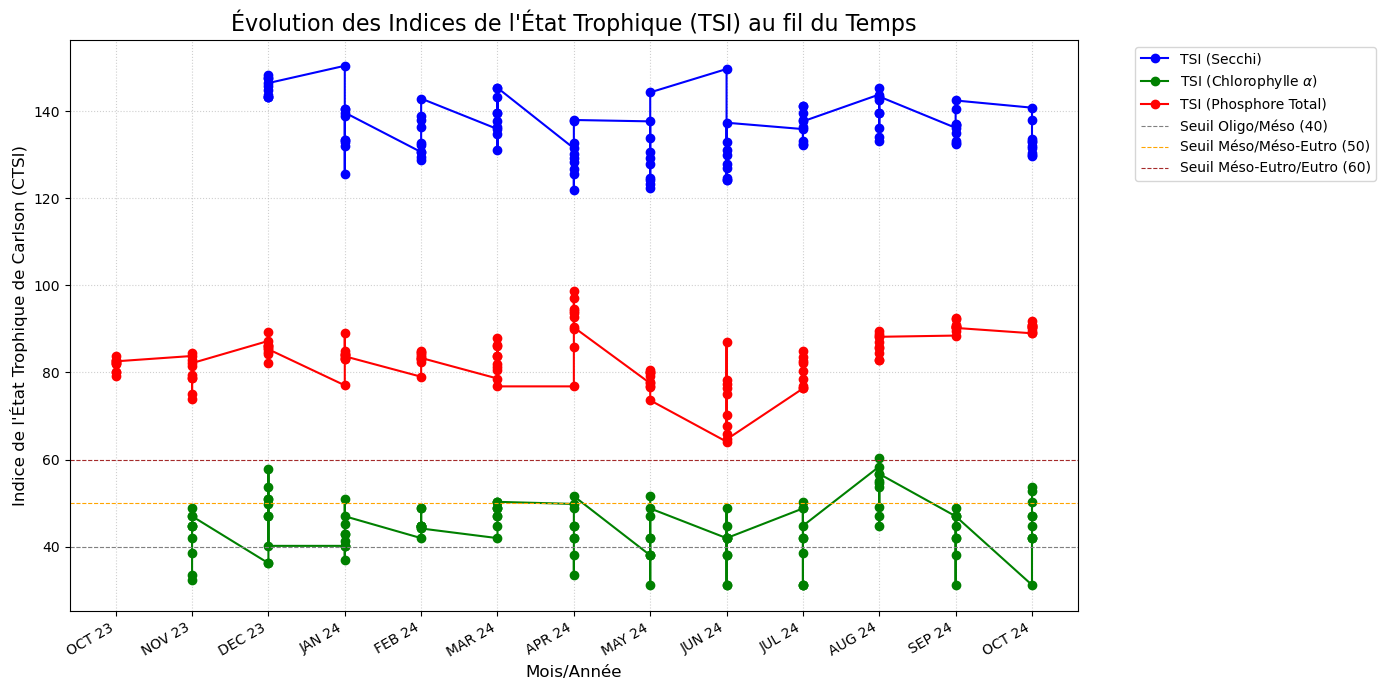

In [74]:
# Mise en place de la figure
plt.figure(figsize=(14, 7))

# --- Tracé des trois TSI ---

plt.plot(carlson['Month_Year'], carlson['TSI(SD)'], label='TSI (Secchi)', marker='o', linestyle='-', color='blue')
plt.plot(carlson['Month_Year'], carlson['TSI(CHA)'], label='TSI (Chlorophylle $\\alpha$)', marker='o', linestyle='-', color='green')
plt.plot(carlson['Month_Year'], carlson['TSI(TP)'], label='TSI (Phosphore Total)', marker='o', linestyle='-', color='red')

# --- Ajout des Lignes de Seuil Trophique (Optionnel mais Recommandé) ---
# Ces lignes aident à contextualiser la classification (Oligotrophique, Mésotrophique, Eutrophique)

plt.axhline(y=40, color='gray', linestyle='--', linewidth=0.8, label='Seuil Oligo/Méso (40)')
plt.axhline(y=50, color='orange', linestyle='--', linewidth=0.8, label='Seuil Méso/Méso-Eutro (50)')
plt.axhline(y=60, color='brown', linestyle='--', linewidth=0.8, label='Seuil Méso-Eutro/Eutro (60)')

# --- Personnalisation du Graphique ---

plt.title('Évolution des Indices de l\'État Trophique (TSI) au fil du Temps', fontsize=16)
plt.xlabel('Mois/Année', fontsize=12)
plt.ylabel("Indice de l\'État Trophique de Carlson (CTSI)", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10) # Légende à l'extérieur
plt.grid(True, linestyle=':', alpha=0.6)

# Formatage de l'axe X pour afficher les dates clairement
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("Etattrophique.png")
plt.show()

## Boxplot temporelle Parametres physique

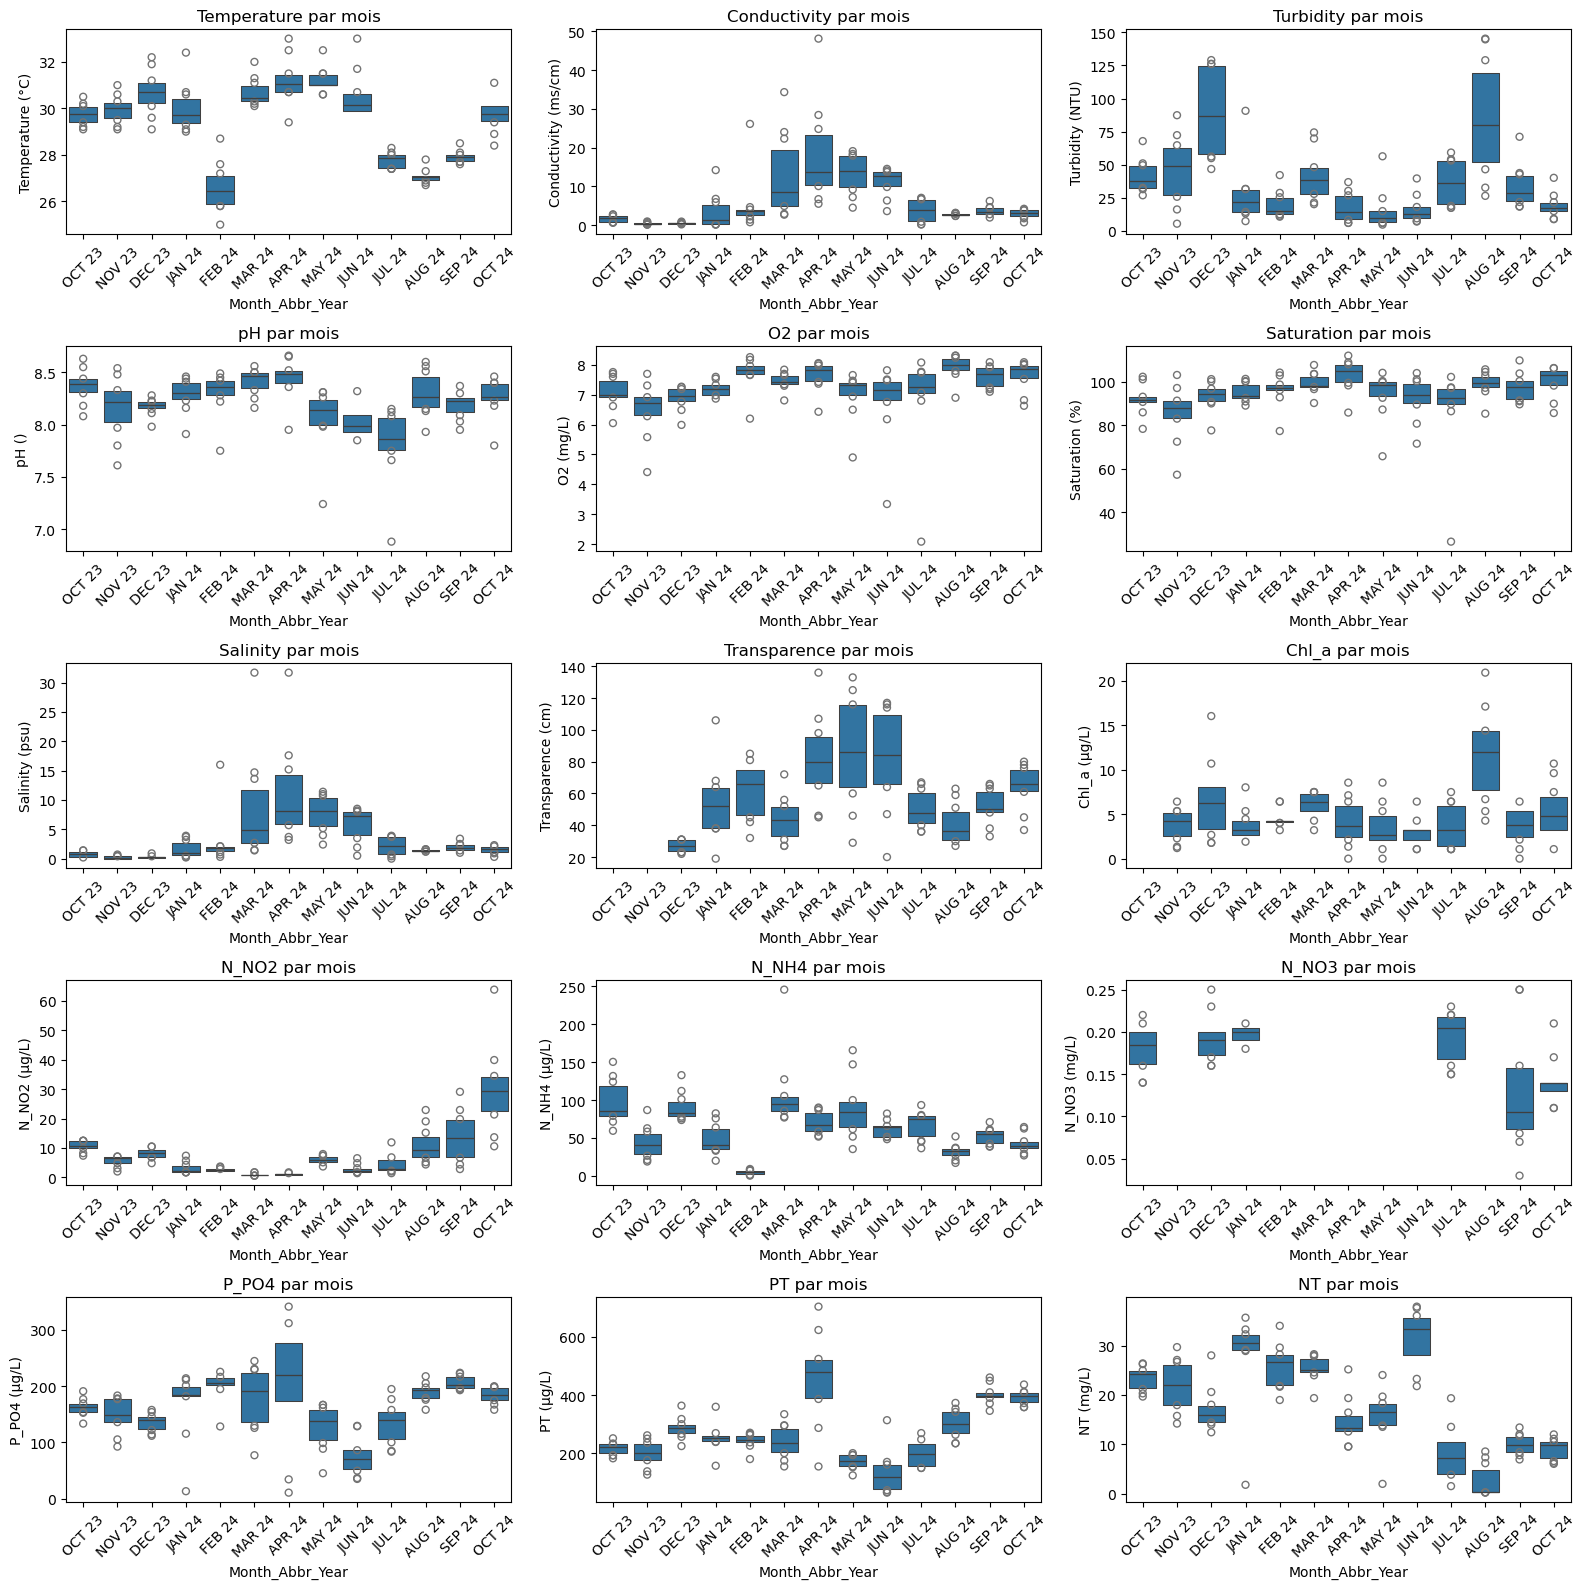

In [9]:
# Convertir la colonne 'Date' en format datetime
data = df_copy
data['Date'] = pd.to_datetime(data['Date'])

# Extraire le mois et l'année pour des moyennes mensuelles
data['Year-Month'] = data['Date'].dt.to_period('M')

# Liste des paramètres physico-chimiques à analyser
parameters = [
    'Temperature', 'Conductivity', 'Turbidity','pH', 'O2', 'Saturation',  'Salinity',
     'Transparence', 'Chl_a', 'N_NO2', 'N_NH4', 'N_NO3',
    'P_PO4', 'PT', 'NT'
]

# Dictionnaire des unités pour chaque paramètre
units = {
    'Temperature': '°C',
    'Conductivity': 'ms/cm',
    'Salinity': 'psu',
    'O2': 'mg/L',
    'Saturation': '%',
    'pH': '',
    'Redox': 'mV',
    'Transparence': 'cm',
    'Turbidity': 'NTU',
    'Chl_a': 'µg/L',
    'N_NO2': 'µg/L',
    'N_NH4': 'µg/L',
    'N_NO3': 'mg/L',
    'P_PO4': 'µg/L',
    'PT': 'µg/L',
    'NT': 'mg/L'
}

# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(16, 16))

# Créer une liste des mois sous forme de chaînes de 3 lettres
data['Month_Abbr_Year'] = data['Date'].dt.strftime('%b %y').str.upper()

for i, param in enumerate(parameters, 1):
    plt.subplot(5, 3, i)  # 4x4 grid for 16 parameters
    sns.boxenplot(data=data, x='Month_Abbr_Year', y=param)
    plt.title(f'{param} par mois')
    plt.ylabel(f'{param} ({units[param]})')  # Ajouter l'unité à l'axe y
    plt.xticks(rotation=45)

#for i, param in enumerate(parameters, 4):
    #plt.subplot(4, 3, i)  # 4x4 grid for 16 parameters
    #sns.boxplot(data=data, x='Stations', y=param, color=".8", linecolor="#137", linewidth=.75)
    #plt.title(f'{param} par mois')
    #plt.ylabel(f'{param} ({units[param]})')  # Ajouter l'unité à l'axe y
    #plt.xticks(rotation=45)

plt.tight_layout()
#plt.savefig('BplotAnaltemppp.png')
plt.show()


ValueError: num must be an integer with 1 <= num <= 12, not 13

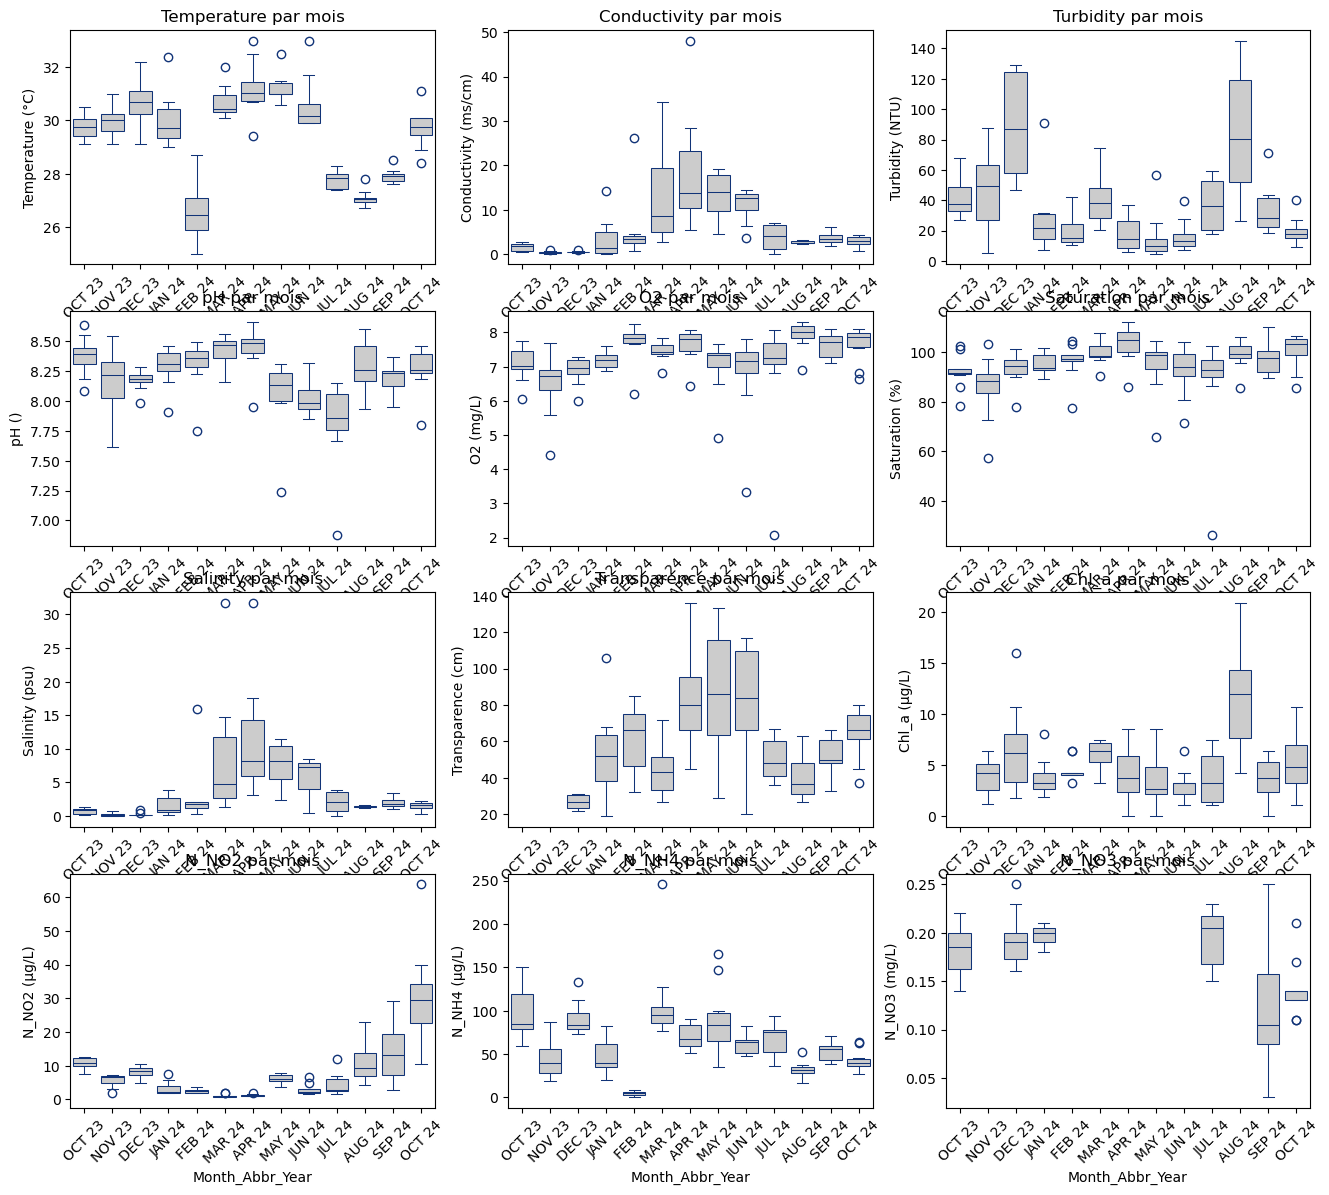

In [10]:
# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(16, 14))

# Créer une liste des mois sous forme de chaînes de 3 lettres
data['Month_Abbr_Year'] = data['Date'].dt.strftime('%b %y').str.upper()

for i, param in enumerate(parameters, 1):
    plt.subplot(4, 3, i)  # 4x4 grid for 16 parameters
    sns.boxplot(data=data, x='Month_Abbr_Year', y=param, color=".8", linecolor="#137", linewidth=.75)
    plt.title(f'{param} par mois')
    plt.ylabel(f'{param} ({units[param]})')  # Ajouter l'unité à l'axe y
    plt.xticks(rotation=45)

#for i, param in enumerate(parameters, 4):
    #plt.subplot(4, 3, i)  # 4x4 grid for 16 parameters
    #sns.boxplot(data=data, x='Stations', y=param, color=".8", linecolor="#137", linewidth=.75)
    #plt.title(f'{param} par mois')
    #plt.ylabel(f'{param} ({units[param]})')  # Ajouter l'unité à l'axe y
    #plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('BplotAnaltemppp.png')
plt.show()

## Boxplot Spatialle Parametres physique

In [ ]:
# Liste des paramètres physico-chimiques à analyser
parameters = ['Temperature', 'Conductivity', 'Turbidity']

# Dictionnaire des unités pour chaque paramètre
units = {
    'Temperature': '°C',
    'Conductivity': 'ms/cm',
    'Salinity': 'psu',
    'O2': 'mg/L',
    'Saturation': '%',
    'pH': '',
    'Redox': 'mV',
    'Transparence': 'cm',
    'Turbidity': 'NTU',
    'Chl_a': 'µg/L',
    'N_NO2': 'µg/L',
    'N_NH4': 'µg/L',
    'N_NO3': 'mg/L',
    'P_PO4': 'µg/L',
    'PT': 'µg/L',
    'NT': 'mg/L'
}

# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(14, 6))

for i, param in enumerate(parameters, 1):
    plt.subplot(1, 3, i)  
    sns.boxplot(data=data, x='Stations', y=param, color=".8", linecolor="#137", linewidth=.75)
    plt.title(f'{param} par mois')
    plt.ylabel(f'{param} ({units[param]})')  # Ajouter l'unité à l'axe y
    plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('Analspatialpp.png', dpi =300)
plt.show()

In [ ]:
# Convertir la colonne 'Date' en format datetime
data = df_copy
data['Date'] = pd.to_datetime(data['Date'])

# Extraire le mois et l'année pour des moyennes mensuelles
data['Year-Month'] = data['Date'].dt.to_period('M')

# Liste des paramètres physico-chimiques à analyser
parameters = ['Temperature', 'Conductivity', 'Turbidity']

# Dictionnaire des unités pour chaque paramètre
units = {
    'Temperature': '°C',
    'Conductivity': 'ms/cm',
    'Salinity': 'psu',
    'O2': 'mg/L',
    'Saturation': '%',
    'pH': '',
    'Redox': 'mV',
    'Transparence': 'cm',
    'Turbidity': 'NTU',
    'Chl_a': 'µg/L',
    'N_NO2': 'µg/L',
    'N_NH4': 'µg/L',
    'N_NO3': 'mg/L',
    'P_PO4': 'µg/L',
    'PT': 'µg/L',
    'NT': 'mg/L'
}

# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(16, 10))

# Créer une liste des mois sous forme de chaînes de 3 lettres
data['Month_Abbr_Year'] = data['Date'].dt.strftime('%b %y').str.upper()

for i, param in enumerate(parameters, 1):
    plt.subplot(2, 3, i)  # 4x4 grid for 16 parameters
    sns.boxplot(data=data, x='Month_Abbr_Year', y=param, color=".8", linecolor="#137", linewidth=.75)
    plt.title(f'{param} par mois')
    plt.ylabel(f'{param} ({units[param]})')  # Ajouter l'unité à l'axe y
    plt.xticks(rotation=45)

for i, param in enumerate(parameters, 4):
    plt.subplot(2, 3, i)  # 4x4 grid for 16 parameters
    sns.boxplot(data=data, x='Stations', y=param, color=".8", linecolor="#137", linewidth=.75)
    plt.title(f'{param} par mois')
    plt.ylabel(f'{param} ({units[param]})')  # Ajouter l'unité à l'axe y
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('AnalSpatiotemppp.png', dpi =300)
plt.show()

## Nutriments

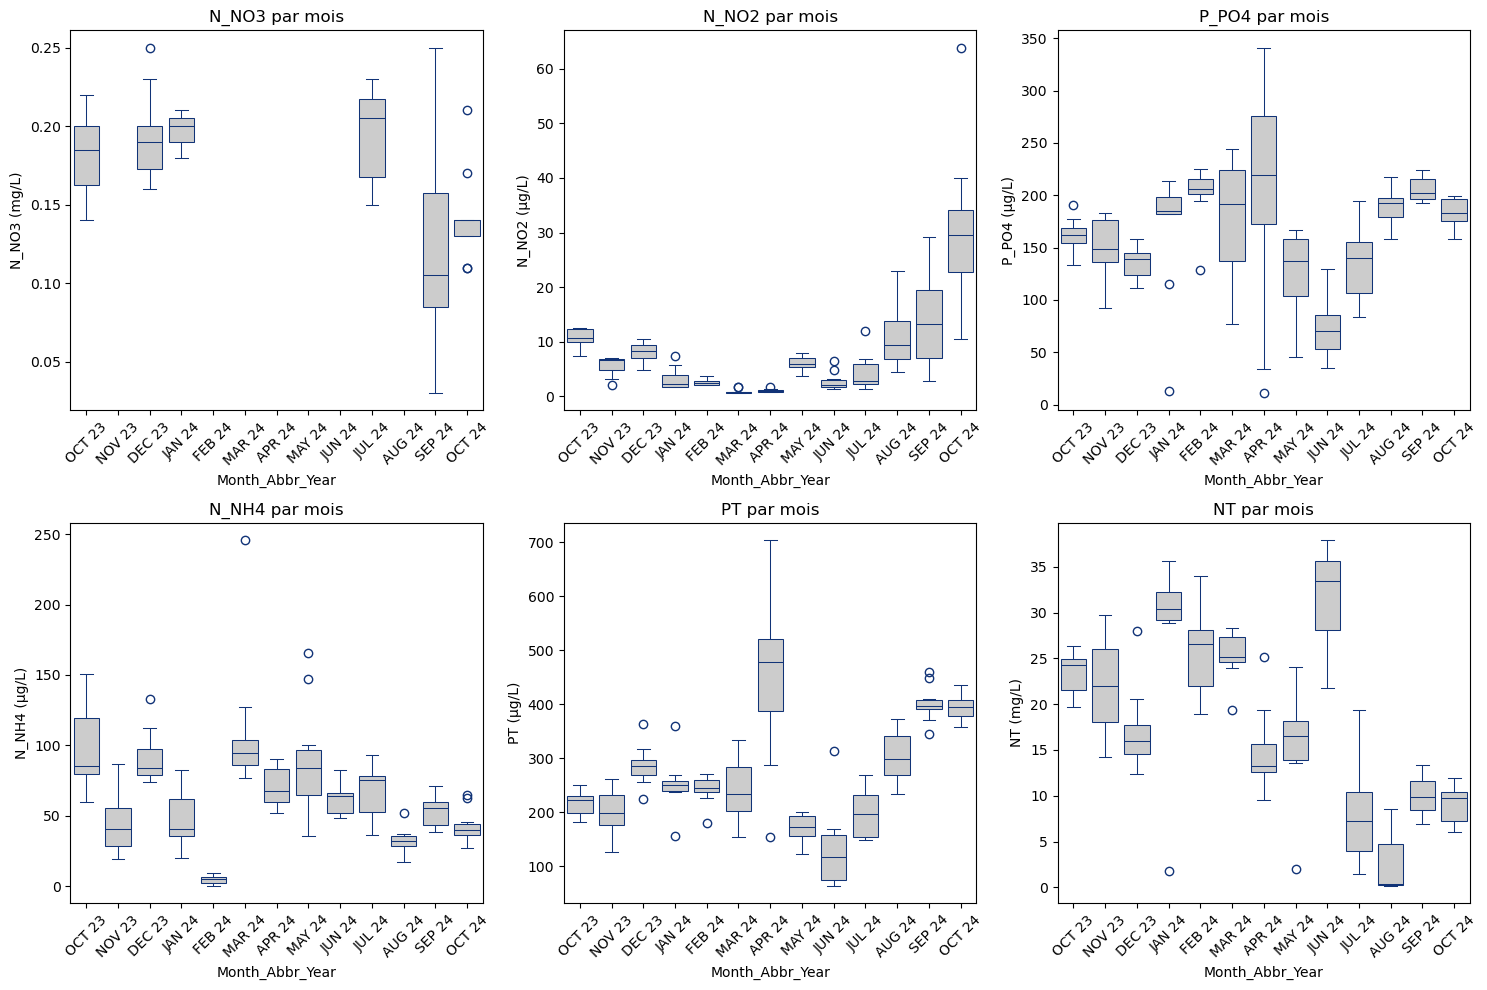

In [11]:
# Liste des paramètres physico-chimiques à analyser
parameters = ['N_NO3', 'N_NO2', 'P_PO4','N_NH4', 'PT', 'NT' ]

# Dictionnaire des unités pour chaque paramètre
units = {
    'Temperature': '°C',
    'Conductivity': 'ms/cm',
    'Salinity': 'psu',
    'O2': 'mg/L',
    'Saturation': '%',
    'pH': '',
    'Redox': 'mV',
    'Transparence': 'cm',
    'Turbidity': 'NTU',
    'Chl_a': 'µg/L',
    'N_NO2': 'µg/L',
    'N_NH4': 'µg/L',
    'N_NO3': 'mg/L',
    'P_PO4': 'µg/L',
    'PT': 'µg/L',
    'NT': 'mg/L'
}

# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(15, 10))

for i, param in enumerate(parameters, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(data=data, x='Month_Abbr_Year', y=param,color=".8", linecolor="#137", linewidth=.75)
    plt.title(f'{param} par mois')
    plt.ylabel(f'{param} ({units[param]})')  # Ajouter l'unité à l'axe y
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('Analnutriment.png', dpi =300)
plt.show()

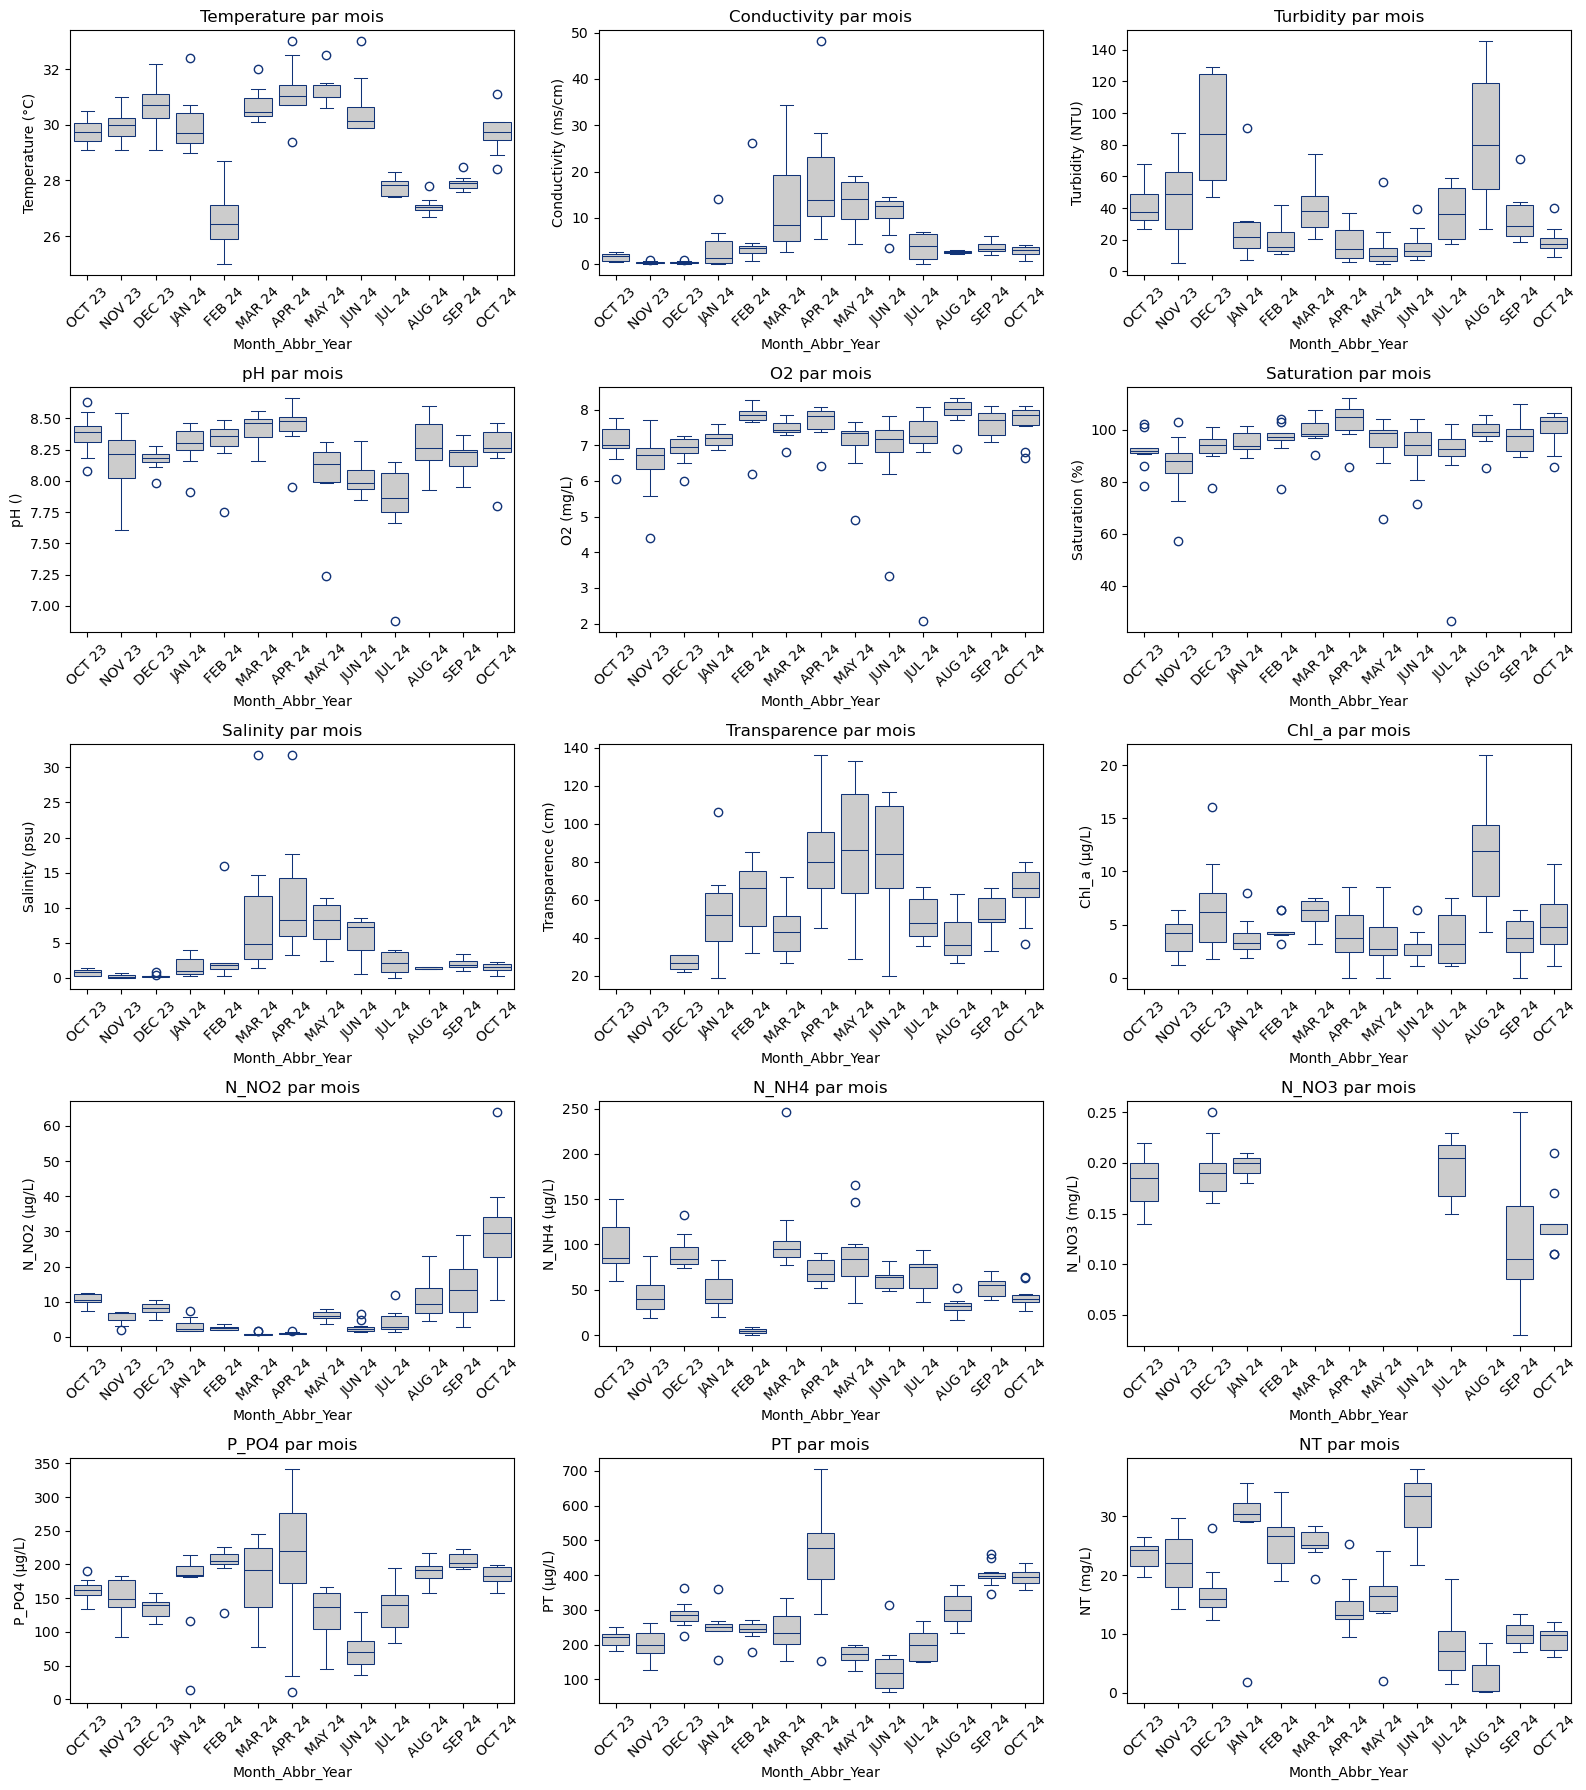

In [12]:
# Liste des paramètres physico-chimiques à analyser
parameters = [
    'Temperature', 'Conductivity', 'Turbidity','pH', 'O2', 'Saturation',  'Salinity',
     'Transparence', 'Chl_a', 'N_NO2', 'N_NH4', 'N_NO3',
    'P_PO4', 'PT', 'NT'
]

# Dictionnaire des unités pour chaque paramètre
units = {
    'Temperature': '°C',
    'Conductivity': 'ms/cm',
    'Salinity': 'psu',
    'O2': 'mg/L',
    'Saturation': '%',
    'pH': '',
    'Redox': 'mV',
    'Transparence': 'cm',
    'Turbidity': 'NTU',
    'Chl_a': 'µg/L',
    'N_NO2': 'µg/L',
    'N_NH4': 'µg/L',
    'N_NO3': 'mg/L',
    'P_PO4': 'µg/L',
    'PT': 'µg/L',
    'NT': 'mg/L'
}

# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(16, 18))

for i, param in enumerate(parameters, 1):
    plt.subplot(5, 3, i)  
    sns.boxplot(data=data, x='Month_Abbr_Year', y=param,color=".8", linecolor="#137", linewidth=.75)
    plt.title(f'{param} par mois')
    plt.ylabel(f'{param} ({units[param]})')  # Ajouter l'unité à l'axe y
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('Variationtemporelle.pdf', dpi =300)
plt.show()

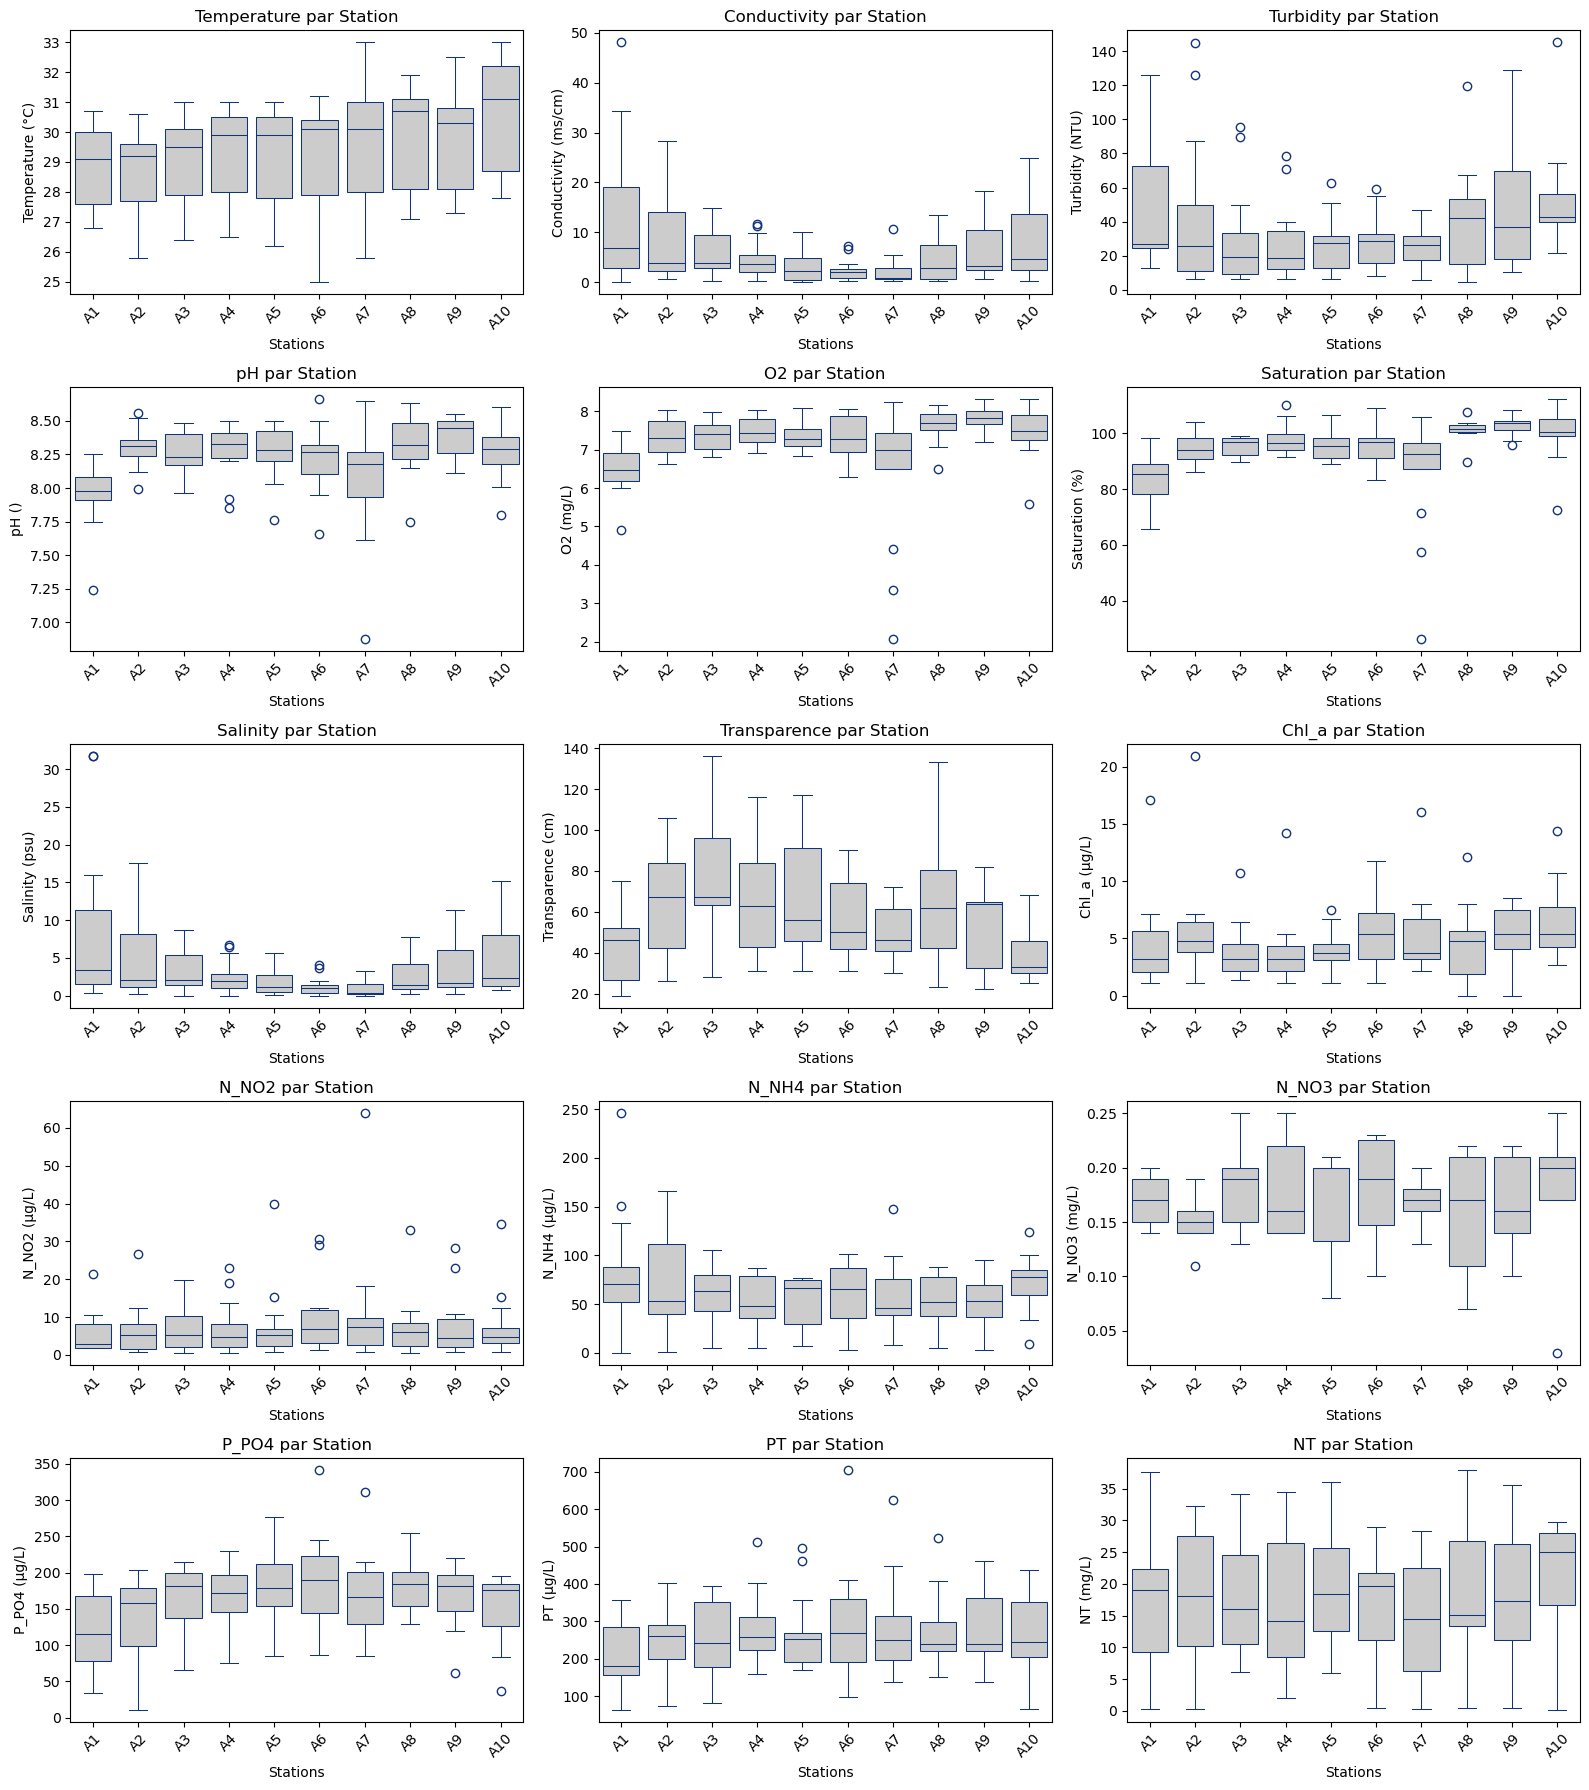

In [13]:
# Liste des paramètres physico-chimiques à analyser
parameters = [
    'Temperature', 'Conductivity', 'Turbidity','pH', 'O2', 'Saturation',  'Salinity',
     'Transparence', 'Chl_a', 'N_NO2', 'N_NH4', 'N_NO3',
    'P_PO4', 'PT', 'NT'
]

# Dictionnaire des unités pour chaque paramètre
units = {
    'Temperature': '°C',
    'Conductivity': 'ms/cm',
    'Salinity': 'psu',
    'O2': 'mg/L',
    'Saturation': '%',
    'pH': '',
    'Redox': 'mV',
    'Transparence': 'cm',
    'Turbidity': 'NTU',
    'Chl_a': 'µg/L',
    'N_NO2': 'µg/L',
    'N_NH4': 'µg/L',
    'N_NO3': 'mg/L',
    'P_PO4': 'µg/L',
    'PT': 'µg/L',
    'NT': 'mg/L'
}

# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(16, 18))

for i, param in enumerate(parameters, 1):
    plt.subplot(5, 3, i)  
    sns.boxplot(data=data, x='Stations', y=param,color=".8", linecolor="#137", linewidth=.75)
    plt.title(f'{param} par Station')
    plt.ylabel(f'{param} ({units[param]})')  # Ajouter l'unité à l'axe y
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('Variationspatiale.png', dpi =300)
plt.show()

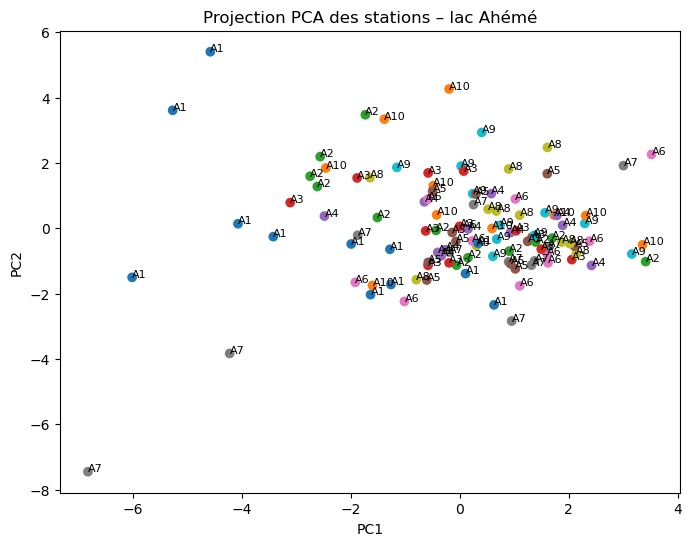

In [14]:

params = ['Temperature', 'Conductivity', 'Turbidity','pH', 'O2', 'Saturation',  'Salinity','Chl_a', 'N_NO2', 'N_NH4','P_PO4', 'PT', 'NT']
X = data[params].dropna()
stations = data['Stations'].loc[X.index].values

# Mise à l'échelle et PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

unique_stations = np.unique(stations)
palette = sns.color_palette('tab10', len(unique_stations))
color_map = dict(zip(unique_stations, palette))

colors = [color_map[s] for s in stations]

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, label=stations)
for i, txt in enumerate(stations):
    plt.annotate(txt, (X_pca[i,0], X_pca[i,1]), fontsize=8)
plt.title("Projection PCA des stations – lac Ahémé")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


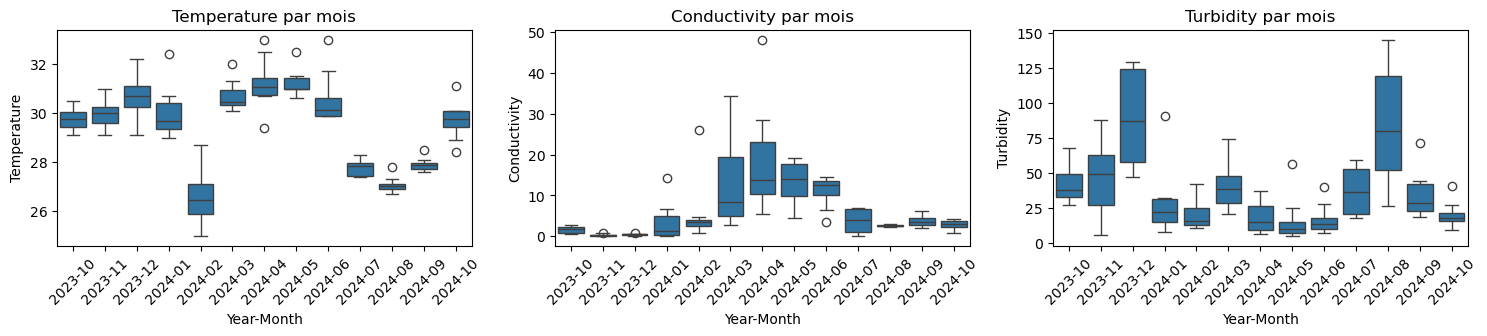

In [15]:
# Convertir la colonne 'Date' en format datetime
data = df_copy
data['Date'] = pd.to_datetime(data['Date'])

# Extraire le mois et l'année pour des moyennes mensuelles
data['Year-Month'] = data['Date'].dt.to_period('M')

# Liste des paramètres physico-chimiques à analyser
parameters = [
    'Temperature', 'Conductivity', 'Turbidity'
]

# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(15, 12))
for i, param in enumerate(parameters, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=data, x='Year-Month', y=param)
    plt.title(f'{param} par mois')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

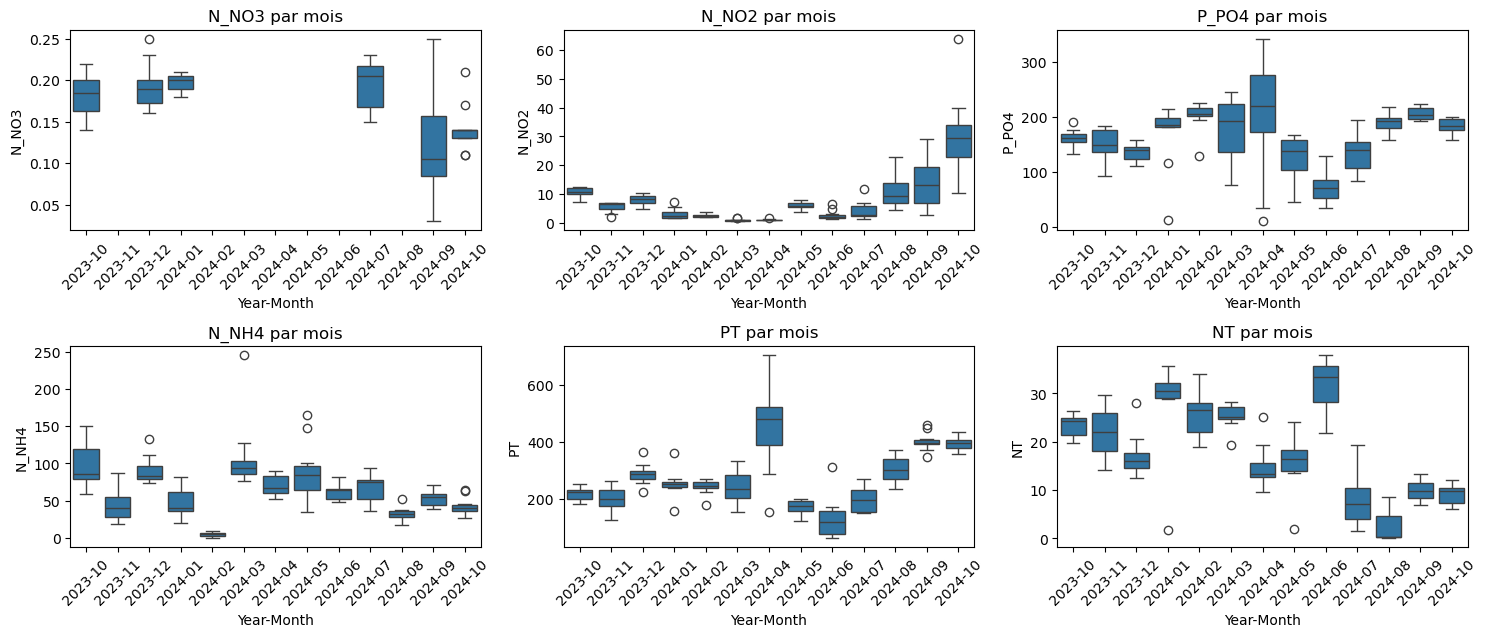

In [16]:
# Liste des paramètres physico-chimiques à analyser
parameters = ['N_NO3', 'N_NO2', 'P_PO4','N_NH4', 'PT', 'NT' ]

# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(15, 12))
for i, param in enumerate(parameters, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=data, x='Year-Month', y=param)
    plt.title(f'{param} par mois')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

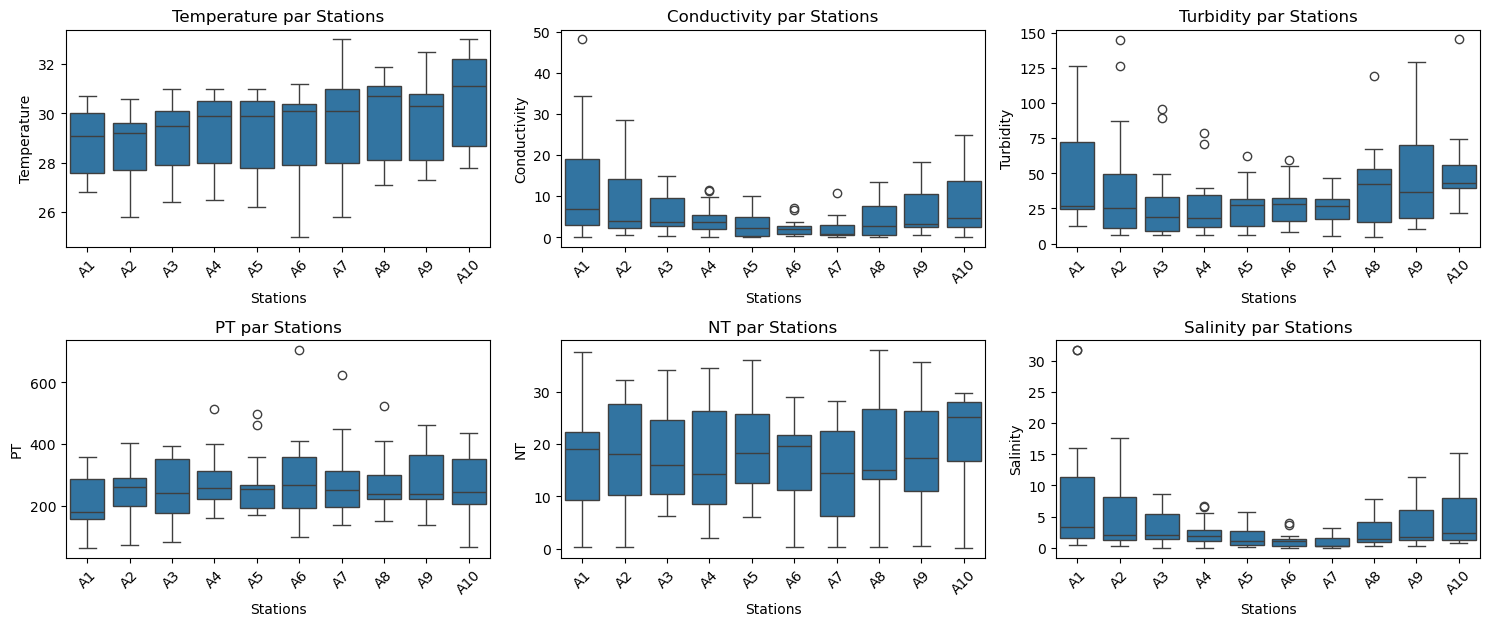

In [17]:
# Liste des paramètres physico-chimiques à analyser
parameters = [
    'Temperature', 'Conductivity', 'Turbidity', 'PT', 'NT','Salinity'
]

# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(15, 12))
for i, param in enumerate(parameters, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=data, x='Stations', y=param)
    plt.title(f'{param} par Stations')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

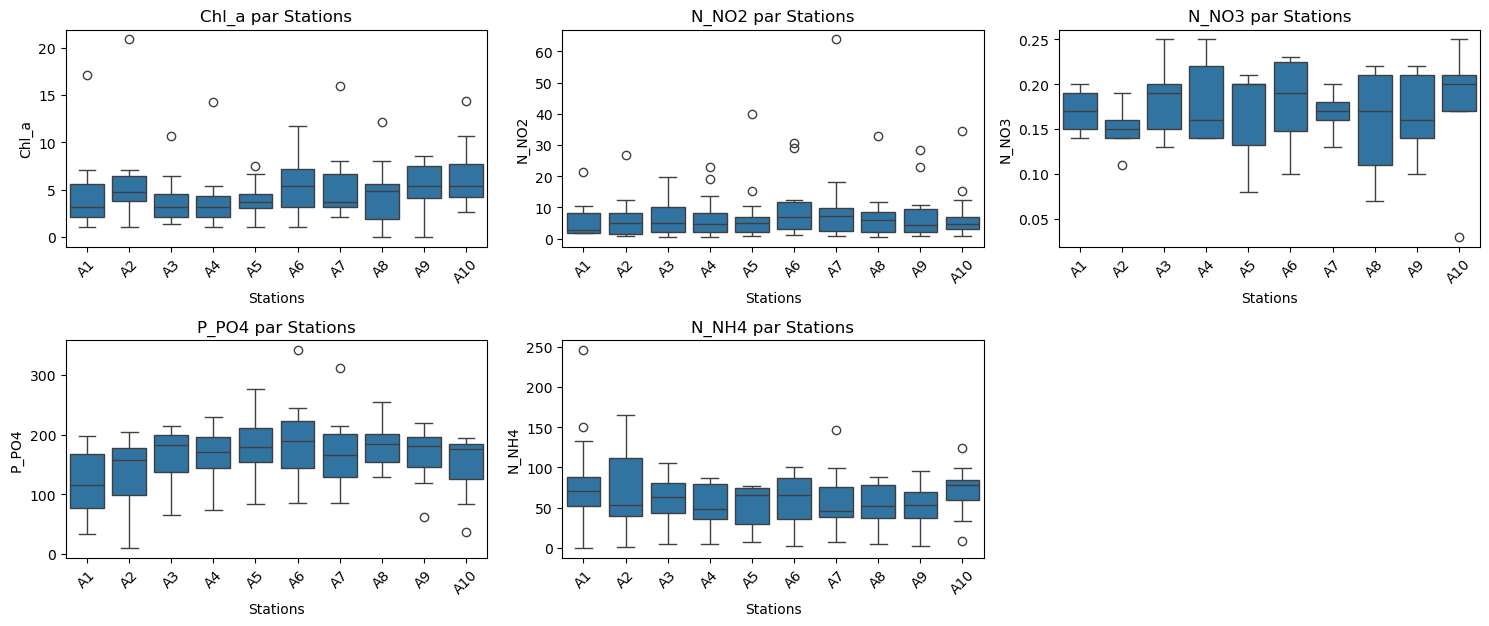

In [18]:
# Convertir la colonne 'Date' en format datetime
data = df_copy
data['Date'] = pd.to_datetime(data['Date'])

# Extraire le mois et l'année pour des moyennes mensuelles
data['Year-Month'] = data['Date'].dt.to_period('M')

# Liste des paramètres physico-chimiques à analyser
parameters = ['Chl_a', 'N_NO2', 'N_NO3', 'P_PO4', 'N_NH4']

# Calcul des moyennes mensuelles par station et par paramètre
monthly_means = data.groupby(['Stations', 'Year-Month'])[parameters].mean().reset_index()

# Tracer des boîtes à moustaches pour chaque paramètre par station et par mois
plt.figure(figsize=(15, 12))
for i, param in enumerate(parameters, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=data, x='Stations', y=param)
    plt.title(f'{param} par Stations')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

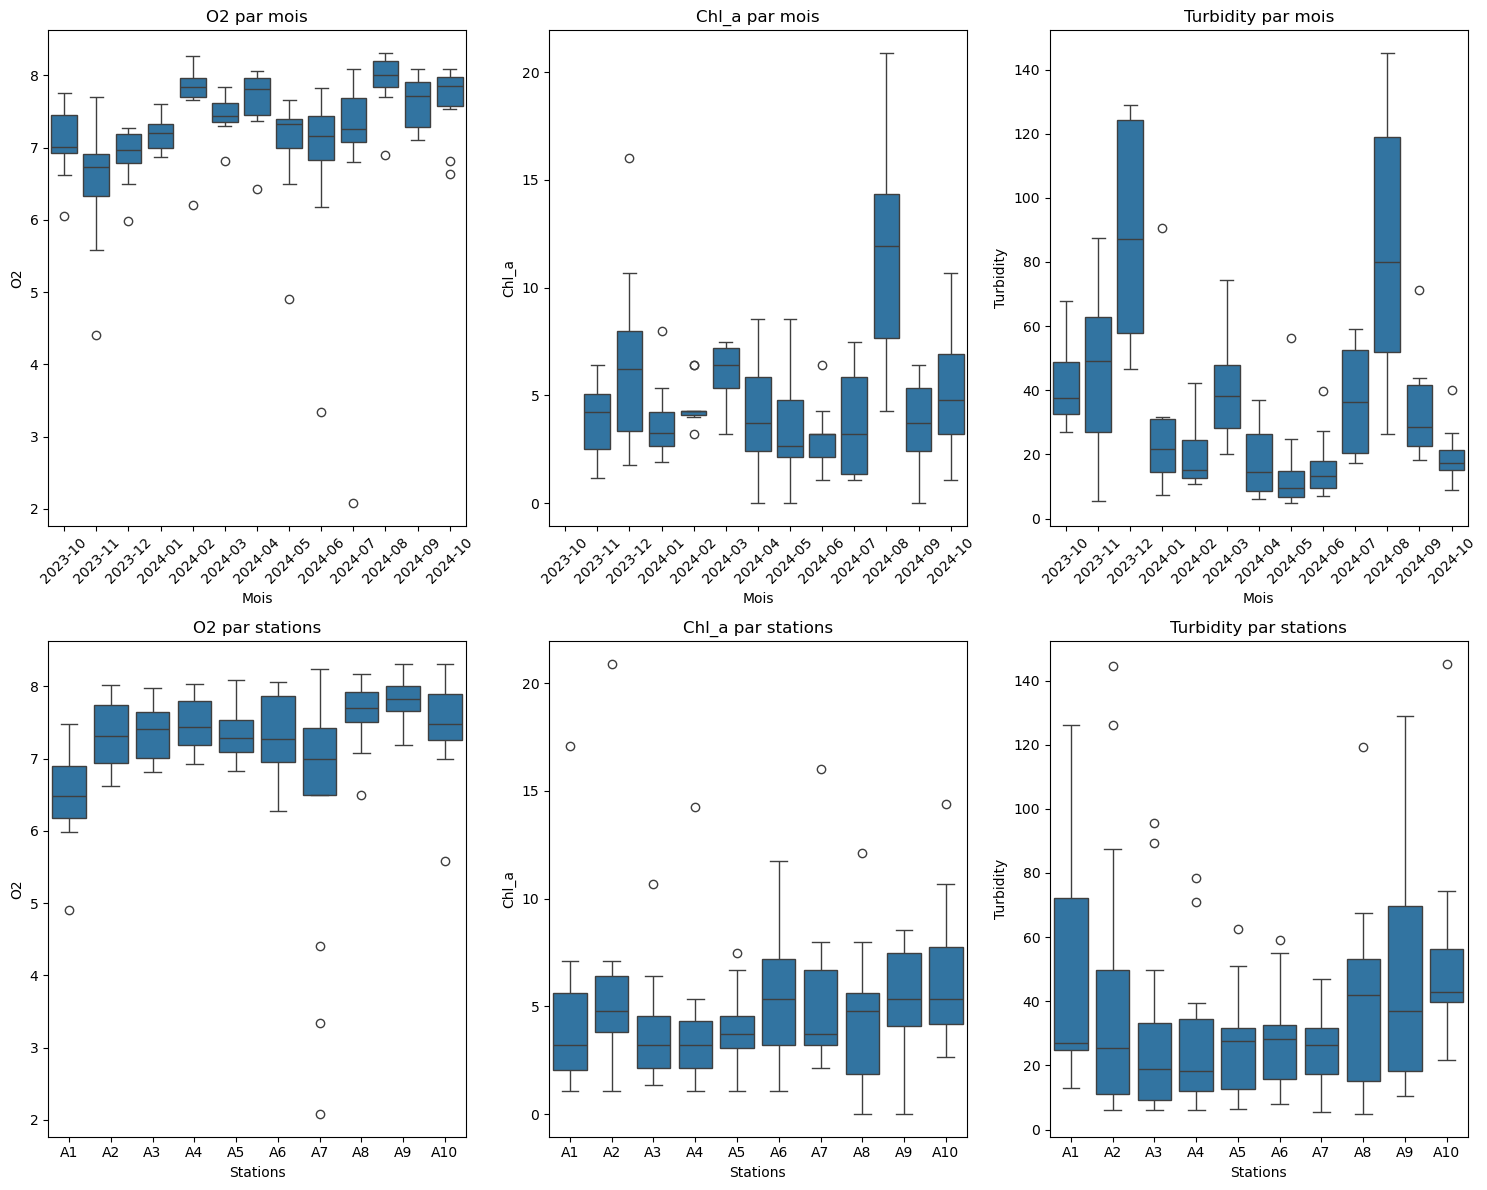

In [19]:
# Convertir la colonne 'Date' en format datetime et extraire le mois
data['Date'] = pd.to_datetime(data['Date'])
data['Mois'] = data['Date'].dt.to_period('M')

# Sélectionner les paramètres à analyser
parameters = ['O2', 'Chl_a', 'Turbidity']

# Créer une figure pour les sous-graphiques
plt.figure(figsize=(15, 12))

# Tracer les boîtes à moustaches pour chaque paramètre par mois
for i, param in enumerate(parameters, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=data, x='Mois', y=param)
    plt.title(f'{param} par mois')
    plt.xticks(rotation=45)

# Tracer les boîtes à moustaches pour chaque paramètre par station
for i, param in enumerate(parameters, 4):
    plt.subplot(2, 3, i)
    sns.boxplot(data=data, x='Stations', y=param)
    plt.title(f'{param} par stations')

plt.tight_layout()
plt.show()

In [20]:
df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='mixed', dayfirst=True)
df_copy['Heure'] = df_copy['Heure'].astype(str)
df_copy['Year_month'] = df_copy['Date'].dt.strftime('%Y-%m')

In [21]:
df_copy.columns

Index(['Date', 'Mois_jr', 'Saison', 'Heure', 'Code', 'Stations', 'X', 'Y',
       'Temperature', 'Conductivity', 'Salinity', 'O2', 'Saturation', 'pH',
       'Redox', 'Transparence', 'Turbidity', 'Chl_a', 'N_NO2', 'N_NH4',
       'N_NO3', 'P_PO4', 'PT', 'NT', 'Long', 'Lat', 'Year-Month',
       'Month_Abbr_Year', 'Mois', 'Year_month'],
      dtype='object')

In [22]:
## 2) Imputation des valeurs manquantes par la moyenne par groupe

In [23]:
def impute_missing(group):
    numeric_cols = group.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        group[col] = group[col].fillna(group[col].mean())
    return group

df_clean = df_copy.groupby(['Saison', 'Stations']).apply(impute_missing).reset_index(drop=True)

In [24]:
#df_clean = df_clean.drop(columns=[['N_NO3']])

In [25]:
# 3) Sélection et renommage des colonnes
cols_to_keep = [col for col in df_clean.columns if not col.startswith('cleaned_')]
df_clean = df_clean[cols_to_keep]

# Supprimer les colonnes spécifiques
cols_to_drop = ['Saison', 'Code', 'Redox','N_NO3']
df_clean = df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns])

In [26]:
# 4) Conversion des types
df_clean['Stations'] = df_clean['Stations'].astype('category')
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

In [27]:
mv = df_clean.isna().sum()
mv

Date               0
Mois_jr            0
Heure              0
Stations           0
X                  0
Y                  0
Temperature        0
Conductivity       0
Salinity           0
O2                 0
Saturation         0
pH                 0
Transparence       0
Turbidity          0
Chl_a              0
N_NO2              0
N_NH4              0
P_PO4              0
PT                 0
NT                 0
Long               0
Lat                0
Year-Month         0
Month_Abbr_Year    0
Mois               0
Year_month         0
dtype: int64

In [28]:
# 5) Sauvegarde du dataframe nettoyé
df_clean.to_csv("df_aheme.csv", index=False)

In [29]:
# 6) Création d'un dataframe numérique seulement
df_num = df_clean.select_dtypes(include=[np.number])
cols_to_exclude = ['X', 'Y', 'Long', 'Lat']
df_num = df_num.drop(columns=[col for col in cols_to_exclude if col in df_num.columns])

In [30]:
df_num.head()

Temperature  Conductivity  Salinity    O2  Saturation    pH  Transparence  \
0         30.7         48.10      31.7  6.43        85.9  7.95         70.57   
1         30.6         19.08      11.4  4.90        65.8  7.24         46.00   
2         30.0         14.50       8.5  6.18        80.8  8.01         20.00   
3         33.0         24.80      15.2  8.04       112.1  8.40         45.00   
4         32.5         18.36      11.0  7.16        99.8  8.01         29.00   

   Turbidity  Chl_a  N_NO2  N_NH4   P_PO4      PT     NT  
0      26.94   7.12   1.73  51.76   34.51  153.94   9.51  
1      24.72   2.14   6.25  87.92   45.41  161.60  19.67  
2      27.34   3.20   1.73  51.18   35.28   63.85  37.63  
3      30.28   8.54   1.44  90.12  172.74  393.98  25.18  
4      56.40   6.41   5.40  99.98   88.82  123.30  18.32

# Analyse descriptive pour chaque paramètre

In [31]:
# Analyse descriptive
desc = df_num.describe()
#desc.to_csv("resultats_descriptifs.csv")
desc

Temperature  Conductivity    Salinity          O2  Saturation  \
count   130.000000    130.000000  130.000000  130.000000  130.000000   
mean     29.470769      6.083923    3.531538    7.253923   94.990615   
std       1.681198      7.631740    5.123090    0.853958   10.470699   
min      25.000000      0.110000    0.000000    2.080000   26.500000   
25%      27.925000      0.907500    0.700000    6.980000   91.175000   
50%      29.900000      3.135000    1.550000    7.365000   96.900000   
75%      30.700000      7.157500    3.875000    7.800000  100.850000   
max      33.000000     48.100000   31.700000    8.310000  112.100000   

               pH  Transparence   Turbidity       Chl_a       N_NO2  \
count  130.000000    130.000000  130.000000  130.000000  130.000000   
mean     8.228846     58.110795   37.610846    4.993538    7.748846   
std      0.261523     25.256197   31.095690    3.472755    9.113788   
min      6.880000     19.000000    4.800000    0.000000    0.600000   
25%      8.142500     40.000000   15.462500    3.200000    2.010000   
50%      8.260000     53.416667   28.180000    4.270000    5.400000   
75%      8.400000     70.427500   49.405000    6.410000    9.360000   
max      8.660000    136.000000  145.200000   20.900000   63.850000   

            N_NH4       P_PO4          PT          NT  
count  130.000000  130.000000  130.000000  130.000000  
mean    62.274154  161.909615  268.765859   18.063910  
std     36.200855   55.621266  109.395284    9.702661  
min      0.240000   10.950000   63.850000    0.180000  
25%     37.755000  130.317500  192.560000   10.467500  
50%     61.335000  171.000000  249.060000   18.170000  
75%     81.075000  198.035000  341.097500   25.435000  
max    245.750000  341.090000  704.240000   37.910000

In [32]:
df_num

Temperature  Conductivity  Salinity    O2  Saturation    pH  \
0           30.7         48.10      31.7  6.43        85.9  7.95   
1           30.6         19.08      11.4  4.90        65.8  7.24   
2           30.0         14.50       8.5  6.18        80.8  8.01   
3           33.0         24.80      15.2  8.04       112.1  8.40   
4           32.5         18.36      11.0  7.16        99.8  8.01   
..           ...           ...       ...   ...         ...   ...   
125         26.9          2.78       1.4  7.70        95.7  8.13   
126         26.7          2.60       1.3  7.97        99.1  8.15   
127         27.0          2.61       1.3  8.24       102.9  8.25   
128         27.1          2.53       1.3  8.07       101.0  8.27   
129         27.3          2.38       1.2  8.31       104.6  8.51   

     Transparence  Turbidity  Chl_a  N_NO2  N_NH4   P_PO4      PT     NT  
0           70.57      26.94   7.12   1.73  51.76   34.51  153.94   9.51  
1           46.00      24.72   2.14   6.25  87.92   45.41  161.60  19.67  
2           20.00      27.34   3.20   1.73  51.18   35.28   63.85  37.63  
3           45.00      30.28   8.54   1.44  90.12  172.74  393.98  25.18  
4           29.00      56.40   6.41   5.40  99.98   88.82  123.30  18.32  
..            ...        ...    ...    ...    ...     ...     ...    ...  
125         51.00      46.56   6.68   4.39  27.21  178.92  263.10   7.33  
126         63.00      32.73  11.75   9.02  30.88  189.73  233.75   0.37  
127         59.00      26.52   4.27   9.79  31.16  195.14  233.75   0.25  
128         40.00      67.46  12.14   6.71  36.23  195.91  287.04   0.37  
129         27.00     128.92   5.34  22.92  37.08  217.53  341.87   0.41  

[130 rows x 14 columns]

In [33]:
def stats_desc(variable):
    """Fonction pour calculer les statistiques descriptives"""
    sd_value = variable.std()
    cv_value = sd_value / variable.mean() if variable.mean() != 0 else np.nan
    
    # Test de Shapiro-Wilk
    try:
        shapiro_stat, shapiro_p = shapiro(variable.dropna())
    except:
        shapiro_stat, shapiro_p = np.nan, np.nan
    
    return pd.Series({
        'Ecart_type': round(sd_value, 2),
        'Coeff_variation': round(cv_value, 2) if not np.isnan(cv_value) else np.nan,
        'W_Shapiro': round(shapiro_stat, 2) if not np.isnan(shapiro_stat) else np.nan,
        'P_Shapiro': shapiro_p
    })

# Application sur toutes les colonnes numériques
resultats = df_num.apply(stats_desc)
resultats['Variables'] = df_num.columns
print(resultats[['Variables', 'Ecart_type', 'Coeff_variation', 'W_Shapiro', 'P_Shapiro']])

# Description détaillée avec scipy
from scipy.stats import describe
print("\nDescription détaillée:")
for col in df_num.columns:
    desc_stats = describe(df_num[col].dropna())
    print(f"{col}: n={desc_stats.nobs}, min={desc_stats.minmax[0]:.2f}, max={desc_stats.minmax[1]:.2f}, mean={desc_stats.mean:.2f}")

ValueError: Length of values (14) does not match length of index (4)

# Calculer la matrice de corrélation pour tous les paramètres

In [34]:
# Matrice de corrélation
cor_matrix = df_num.corr(method='pearson').round(2)
cor_matrix

Temperature  Conductivity  Salinity    O2  Saturation    pH  \
Temperature          1.00          0.30      0.28 -0.20        0.11  0.15   
Conductivity         0.30          1.00      0.97 -0.01        0.09 -0.09   
Salinity             0.28          0.97      1.00  0.03        0.10 -0.08   
O2                  -0.20         -0.01      0.03  1.00        0.93  0.63   
Saturation           0.11          0.09      0.10  0.93        1.00  0.72   
pH                   0.15         -0.09     -0.08  0.63        0.72  1.00   
Transparence         0.12          0.28      0.25  0.10        0.13  0.16   
Turbidity           -0.10         -0.24     -0.23  0.01       -0.01 -0.00   
Chl_a               -0.14         -0.11     -0.10  0.22        0.19  0.23   
N_NO2               -0.09         -0.29     -0.27  0.07        0.06 -0.09   
N_NH4                0.46          0.25      0.32 -0.19       -0.07 -0.06   
P_PO4               -0.21         -0.42     -0.41  0.38        0.35  0.43   
PT                  -0.03         -0.19     -0.19  0.28        0.32  0.31   
NT                   0.31          0.09      0.07 -0.11       -0.04  0.17   

              Transparence  Turbidity  Chl_a  N_NO2  N_NH4  P_PO4    PT    NT  
Temperature           0.12      -0.10  -0.14  -0.09   0.46  -0.21 -0.03  0.31  
Conductivity          0.28      -0.24  -0.11  -0.29   0.25  -0.42 -0.19  0.09  
Salinity              0.25      -0.23  -0.10  -0.27   0.32  -0.41 -0.19  0.07  
O2                    0.10       0.01   0.22   0.07  -0.19   0.38  0.28 -0.11  
Saturation            0.13      -0.01   0.19   0.06  -0.07   0.35  0.32 -0.04  
pH                    0.16      -0.00   0.23  -0.09  -0.06   0.43  0.31  0.17  
Transparence          1.00      -0.67  -0.32  -0.08  -0.09  -0.10 -0.06  0.11  
Turbidity            -0.67       1.00   0.42   0.10   0.14   0.04  0.09 -0.22  
Chl_a                -0.32       0.42   1.00   0.12  -0.10   0.10  0.09 -0.29  
N_NO2                -0.08       0.10   0.12   1.00  -0.10   0.15  0.35 -0.42  
N_NH4                -0.09       0.14  -0.10  -0.10   1.00  -0.15 -0.07  0.10  
P_PO4                -0.10       0.04   0.10   0.15  -0.15   1.00  0.69 -0.21  
PT                   -0.06       0.09   0.09   0.35  -0.07   0.69  1.00 -0.39  
NT                    0.11      -0.22  -0.29  -0.42   0.10  -0.21 -0.39  1.00

In [35]:
cor_matrix.to_csv("resultats_cormatrix.csv")

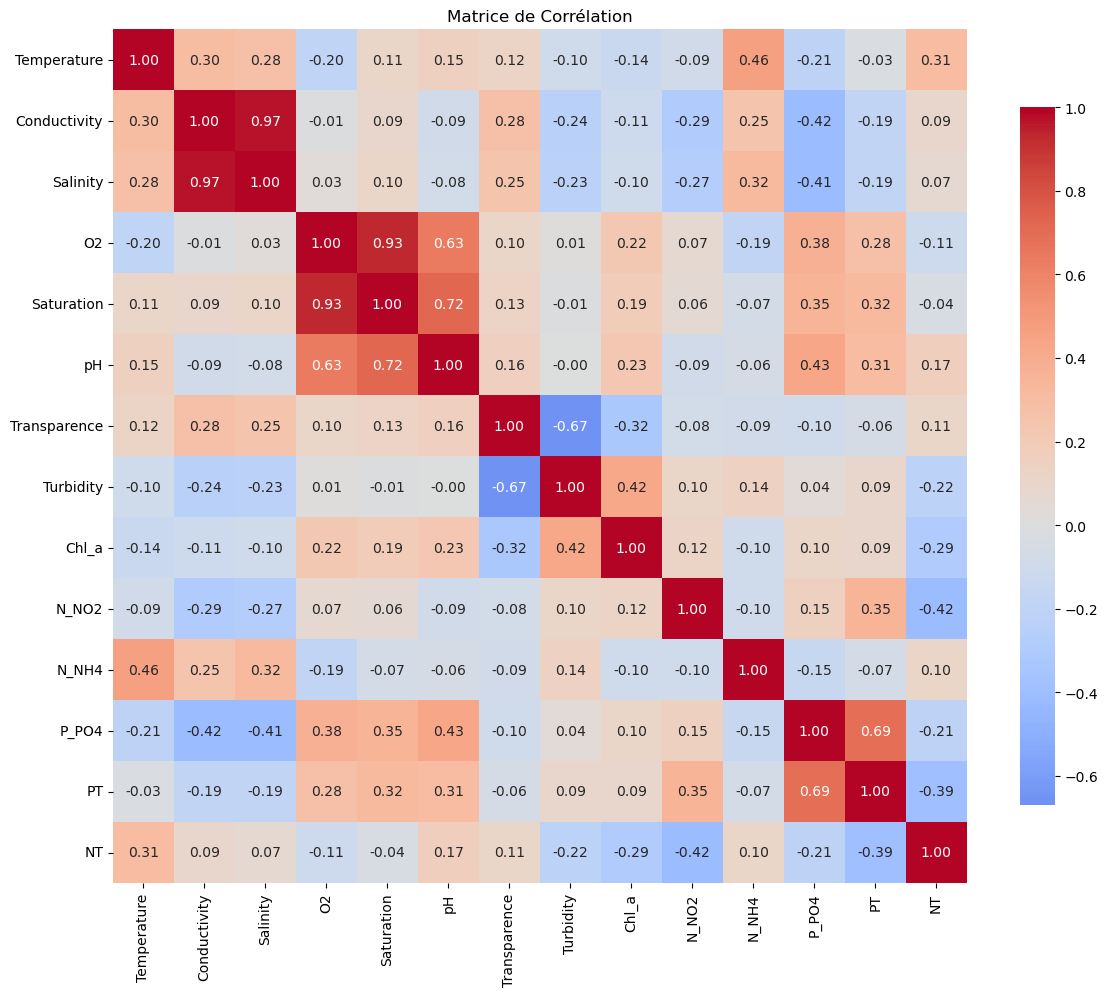

In [36]:
# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Matrice de Corrélation')
plt.tight_layout()
plt.savefig('grap_correlation.png', dpi=300, bbox_inches='tight')
plt.show()
#plt.close()

In [37]:
# Test de significativité des corrélations
from scipy.stats import pearsonr
def calculate_pvalues(df):
    """Calcule les p-values pour la matrice de corrélation"""
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 3)
    return pvalues

pvalues_matrix = calculate_pvalues(df_num)
print("P-values de la corrélation:")
print(pvalues_matrix)

P-values de la corrélation:
             Temperature Conductivity Salinity     O2 Saturation     pH  \
Chl_a              0.103        0.229    0.275   0.01       0.03  0.008   
Conductivity         0.0          0.0      0.0  0.951      0.324  0.331   
NT                   0.0        0.312    0.409  0.233      0.685   0.06   
N_NH4                0.0        0.003      0.0  0.032      0.429  0.495   
N_NO2              0.329        0.001    0.002  0.409      0.489  0.321   
O2                 0.021        0.951    0.725    0.0        0.0    0.0   
PT                 0.713        0.029    0.034  0.001        0.0    0.0   
P_PO4              0.019          0.0      0.0    0.0        0.0    0.0   
Salinity           0.001          0.0      0.0  0.725      0.266  0.343   
Saturation          0.23        0.324    0.266    0.0        0.0    0.0   
Temperature          0.0          0.0    0.001  0.021       0.23  0.078   
Transparence       0.159        0.001    0.005  0.282       0.15  0.076 

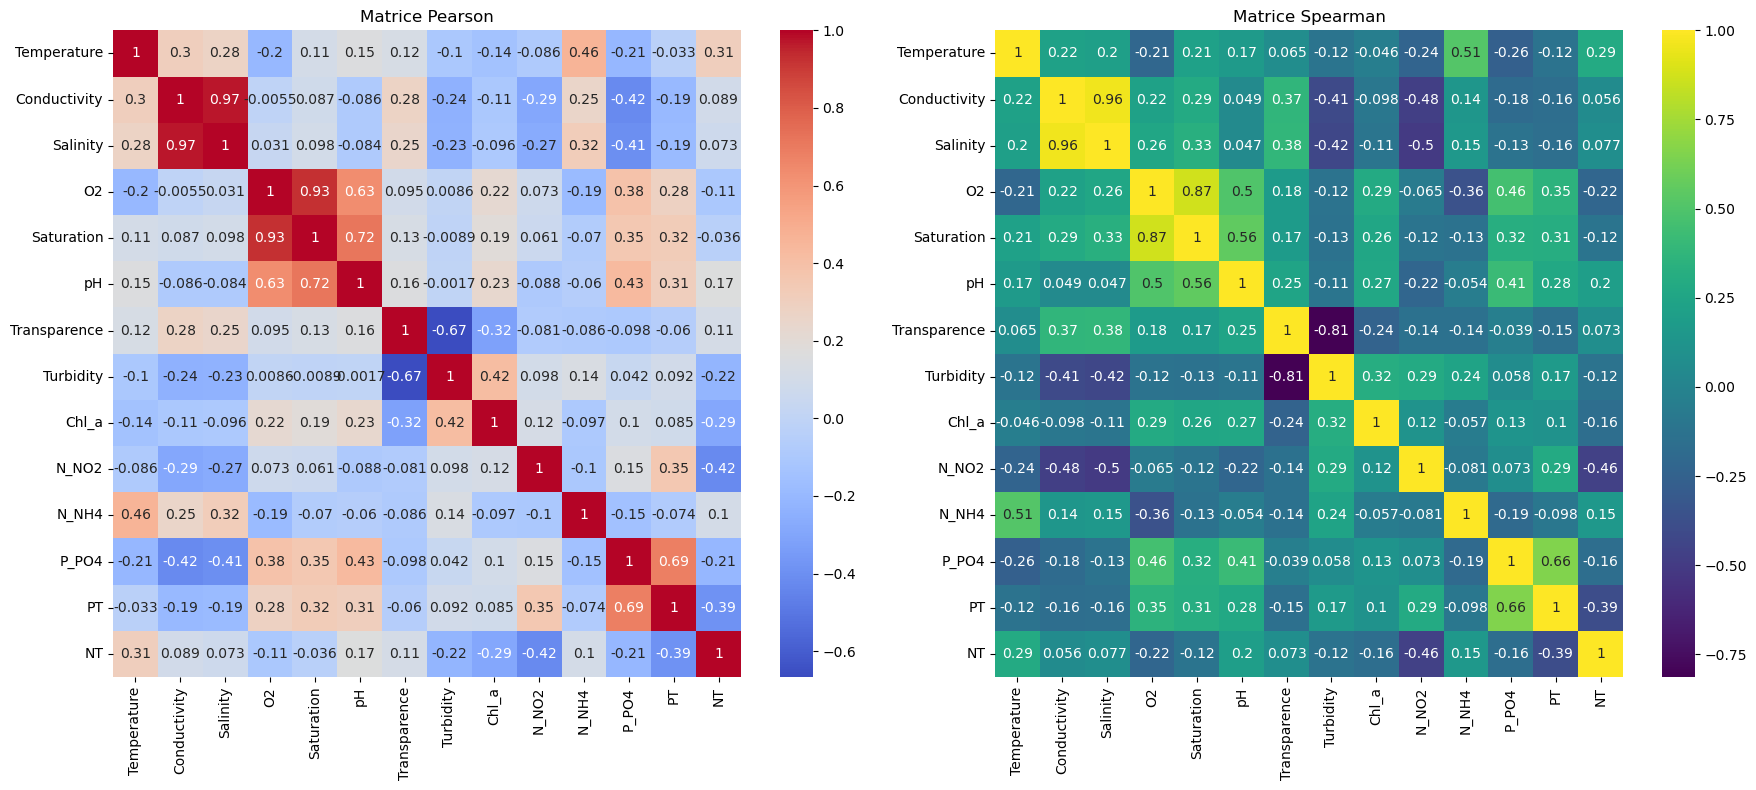

In [46]:
pearson_corr = df_num.corr(method='pearson')
spearman_corr = df_num.corr(method='spearman')

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm")
plt.title("Matrice Pearson")
plt.subplot(1,2,2)
sns.heatmap(spearman_corr, annot=True, cmap="viridis")
plt.title("Matrice Spearman")
plt.tight_layout()
plt.savefig('Pearson_Spearman.png', dpi=300, bbox_inches='tight')
plt.show()

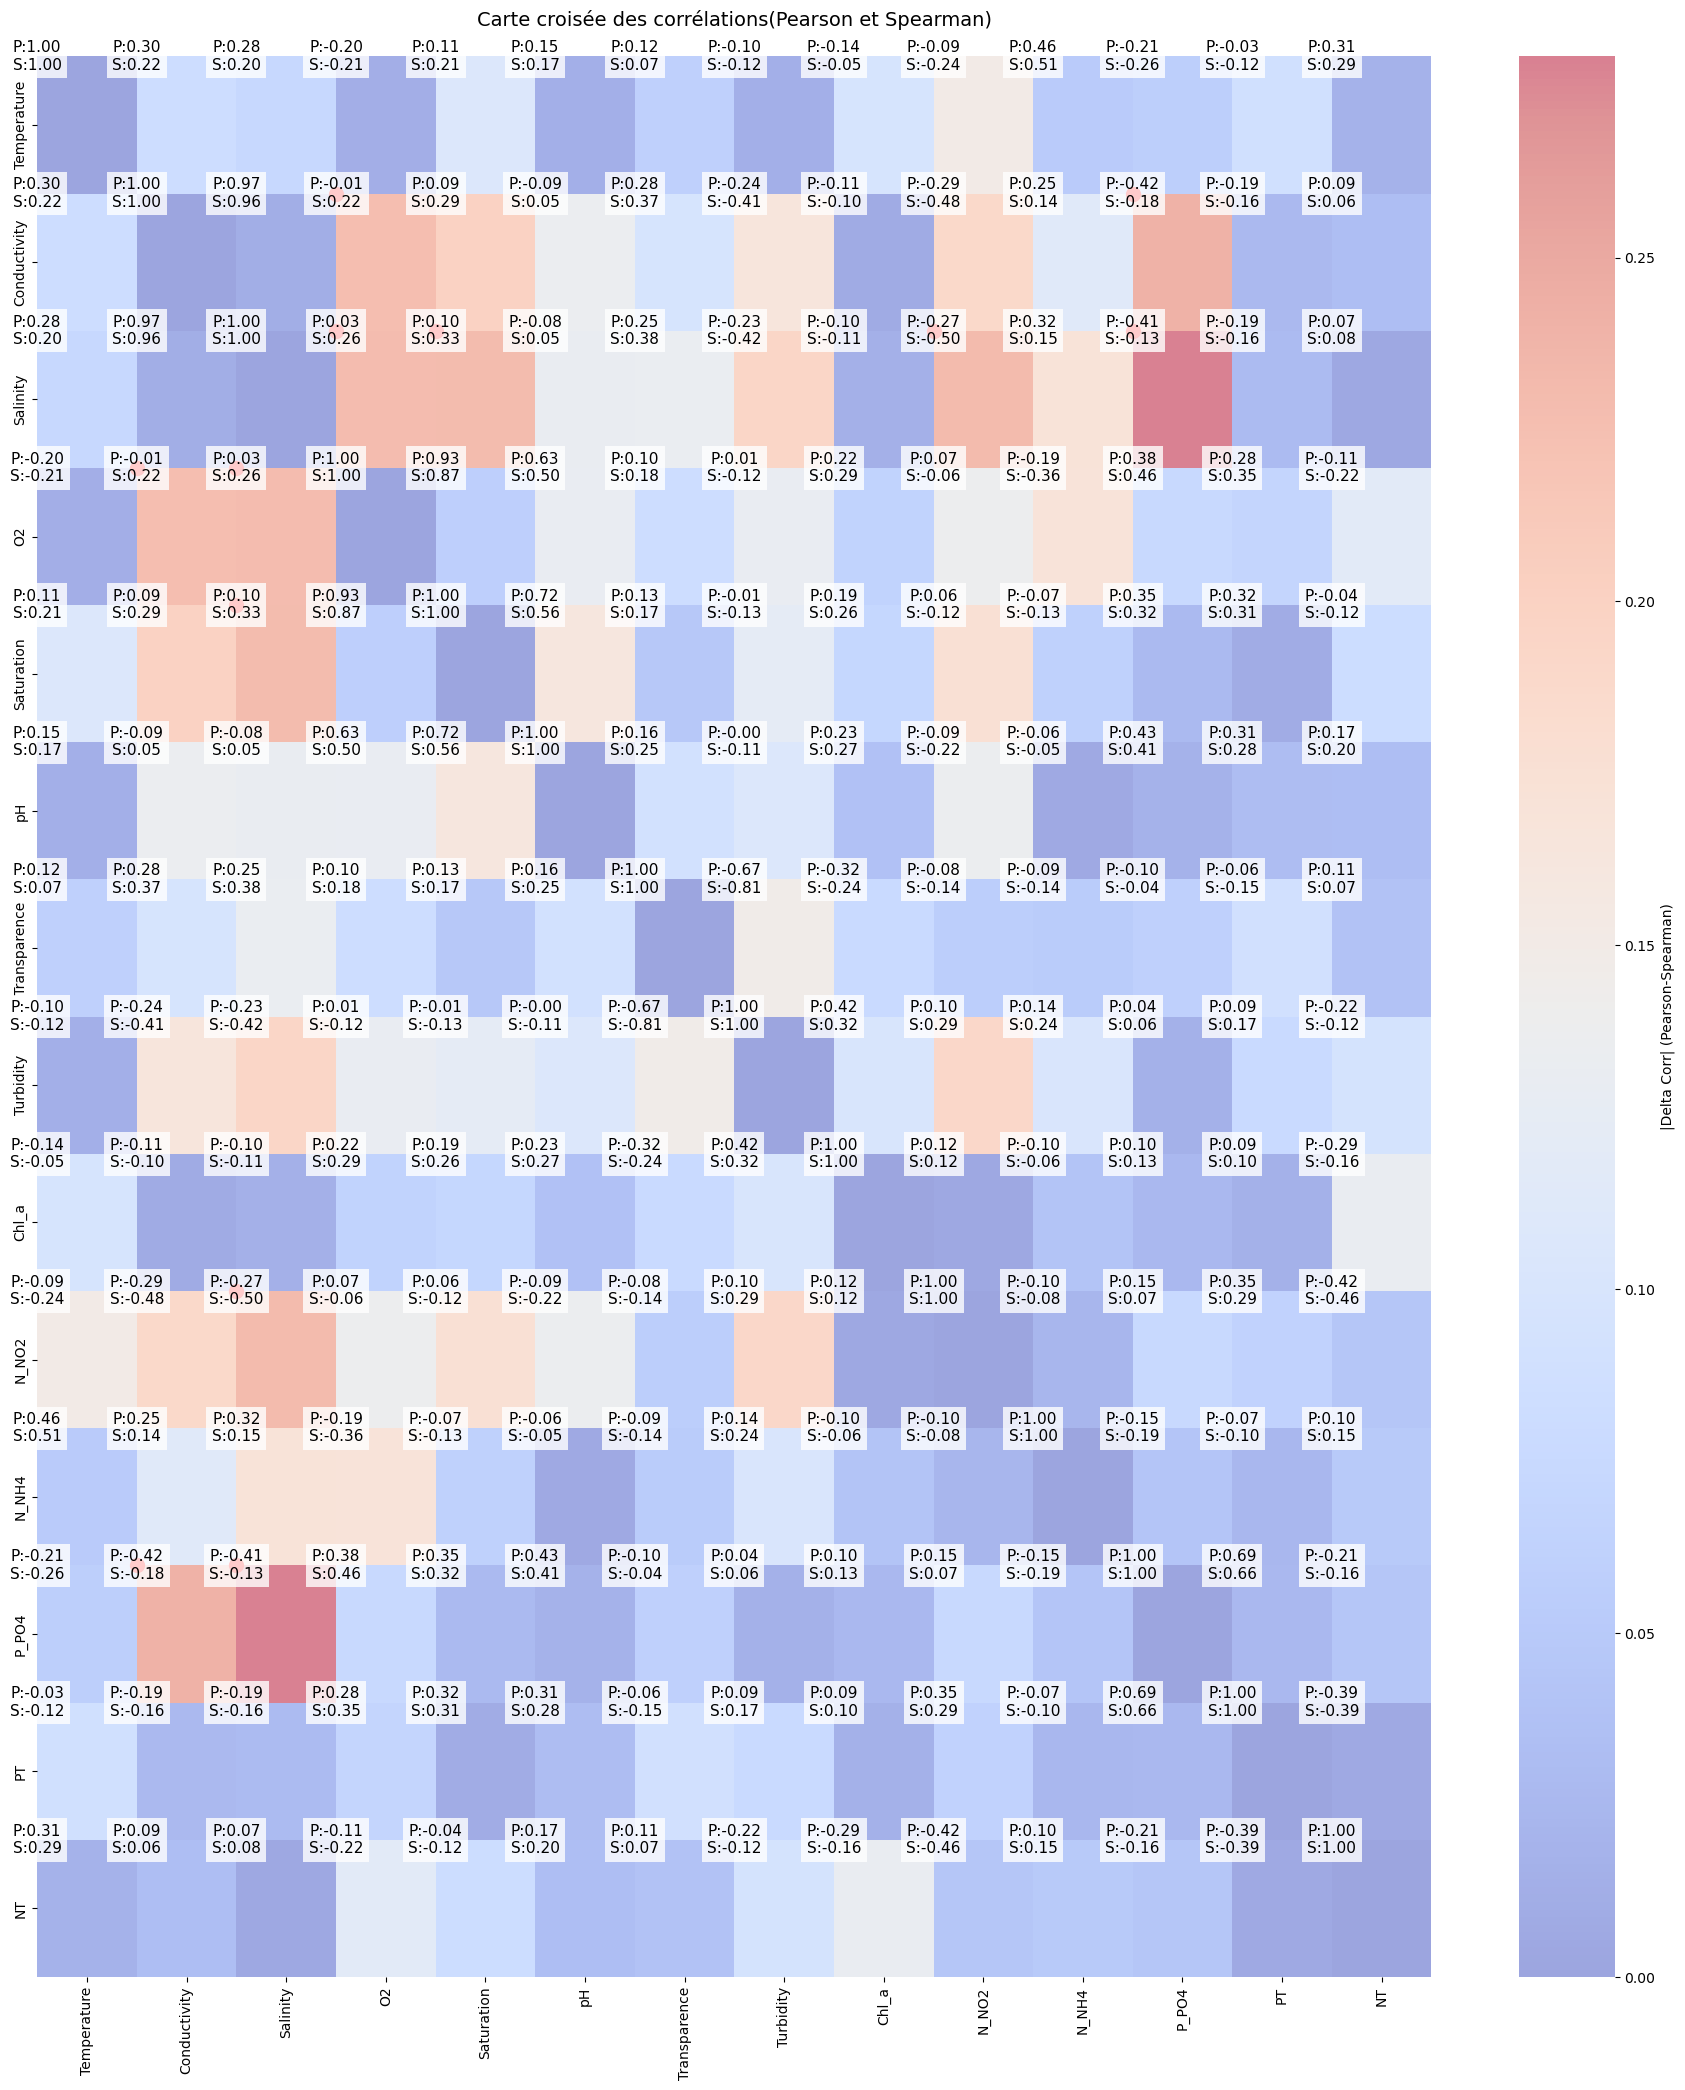

In [56]:
pearson_corr = df_num.corr(method='pearson')
spearman_corr = df_num.corr(method='spearman')

# Matrice de divergences
diff_matrix = np.abs(pearson_corr.values - spearman_corr.values)

fig, ax = plt.subplots(figsize=(18, 21))

# Affichage des coefficients simultanément dans chaque cellule, + point si divergence > 0.2
for i in range(len(df_num.columns)):
    for j in range(len(df_num.columns)):
        # Retrieve coefficients
        pval = pearson_corr.values[i, j]
        sval = spearman_corr.values[i, j]
        txt = f"P:{pval:.2f}\nS:{sval:.2f}"
        ax.text(j, i, txt, ha='center', va='center', fontsize=11,
                color='black',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        # Add red point if divergence is high
        if diff_matrix[i, j] > 0.2 and i != j:
            ax.plot(j, i, 'o', color='red', markersize=10)

sns.heatmap(diff_matrix, annot=False, xticklabels=df_num.columns, yticklabels=df_num.columns,
            cmap="coolwarm", cbar_kws={'label': '|Delta Corr| (Pearson-Spearman)'}, alpha=0.5, ax=ax)

ax.set_title("Carte croisée des corrélations(Pearson et Spearman)\n", fontsize=14)
plt.tight_layout()
plt.show()


In [57]:
# Carte des corrélations en deux axes:

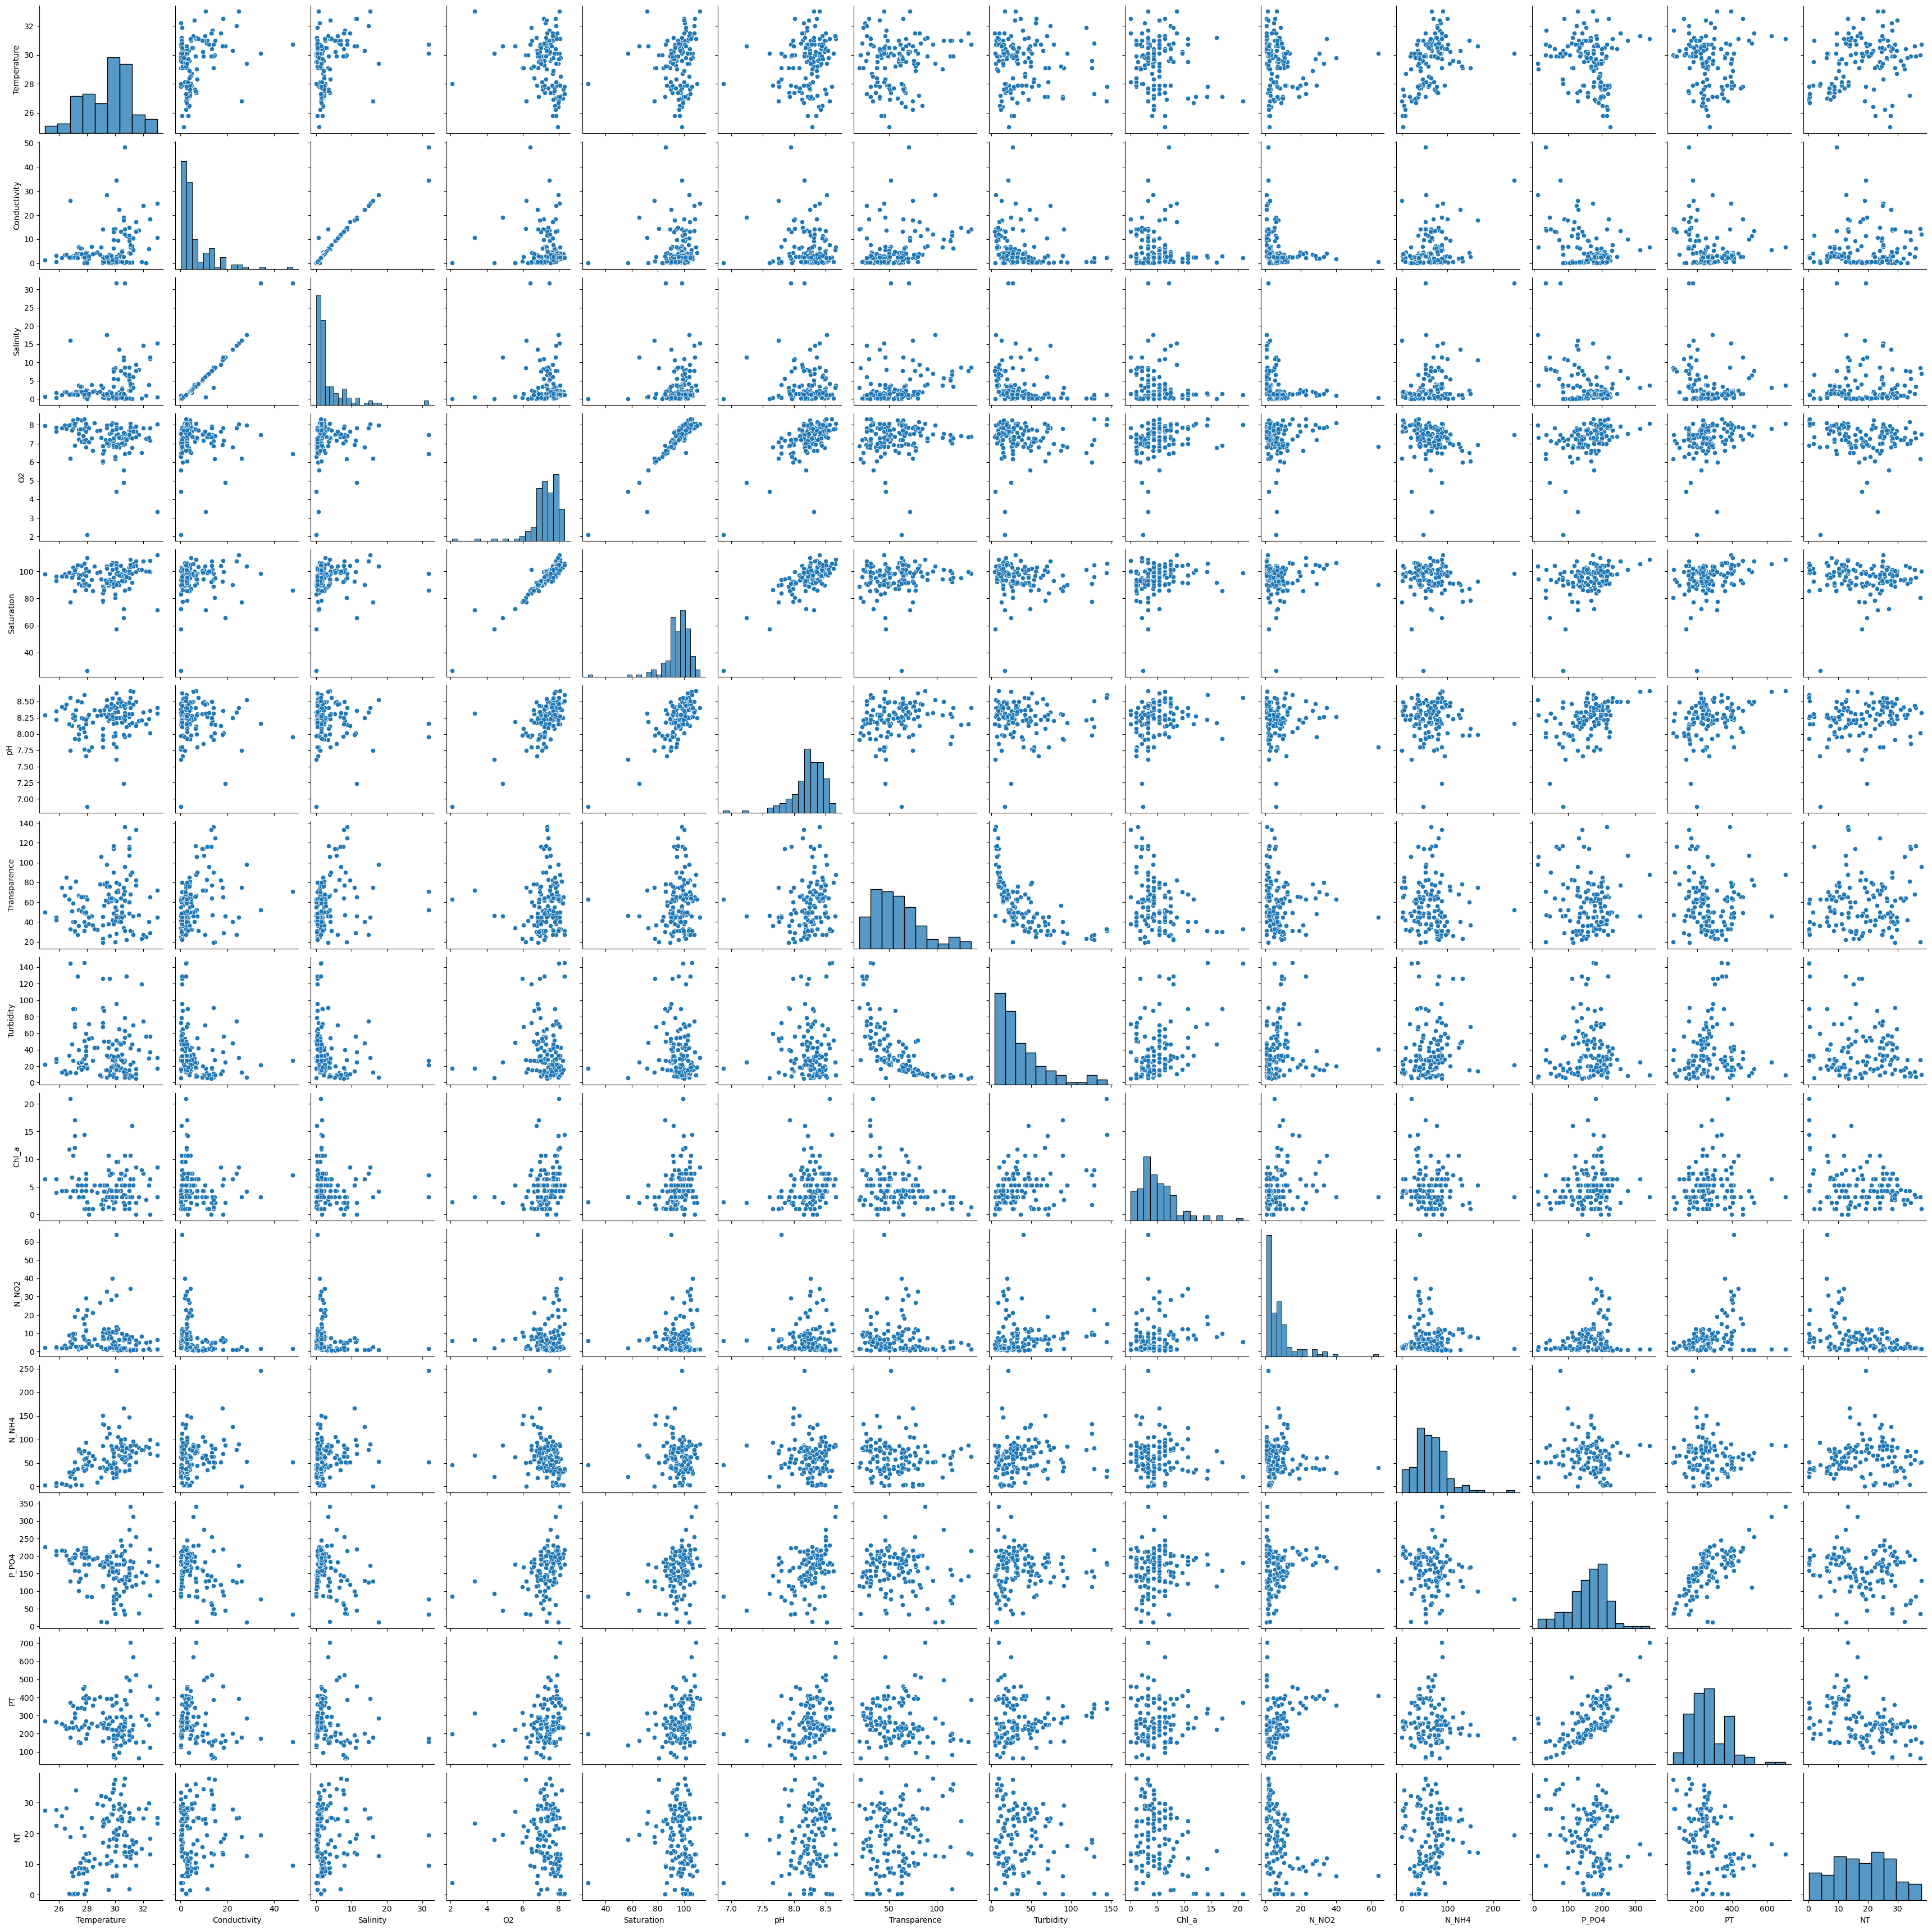

In [58]:
# Diagramme de paires
sns.pairplot(df_num)
plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

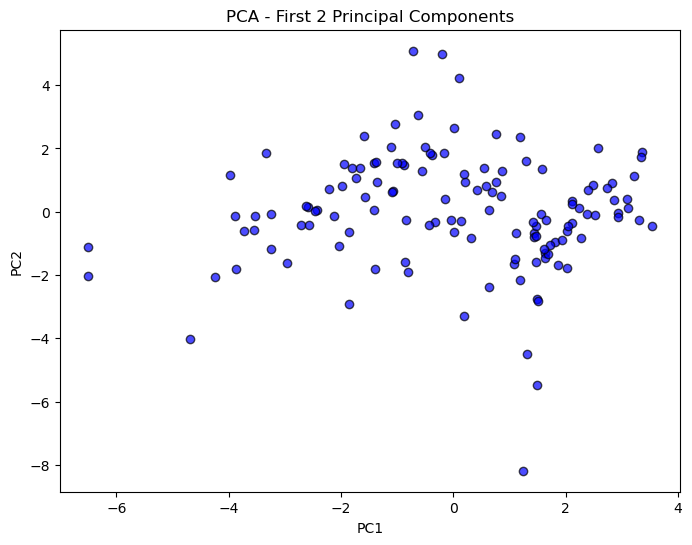

In [59]:
# --- 6. PCA (Principal Component Analysis) ---
# Standardize the data
scaler = StandardScaler()
df_num = df_clean.select_dtypes(include=[np.number])
df_scaled = scaler.fit_transform(df_num)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Visualize PCA results
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', edgecolor='black', alpha=0.7)
plt.title("PCA - First 2 Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("pca_biplot.png")
plt.show()

In [60]:
# ACP
df_scale = StandardScaler().fit_transform(df_num)
pca = PCA()
pca_result = pca.fit_transform(df_scale)

# Résumé de l'ACP
print("Variance expliquée par chaque composante:")
print(pd.DataFrame({
    'Composante': range(1, len(pca.explained_variance_ratio_) + 1),
    'Variance Expliquée': pca.explained_variance_ratio_,
    'Variance Cumulée': np.cumsum(pca.explained_variance_ratio_)
}))

Variance expliquée par chaque composante:
    Composante  Variance Expliquée  Variance Cumulée
0            1        2.579105e-01          0.257910
1            2        1.800139e-01          0.437924
2            3        1.489135e-01          0.586838
3            4        8.198658e-02          0.668824
4            5        7.978477e-02          0.748609
5            6        6.236826e-02          0.810978
6            7        4.613284e-02          0.857110
7            8        3.478242e-02          0.891893
8            9        3.010605e-02          0.921999
9           10        2.272157e-02          0.944720
10          11        1.993567e-02          0.964656
11          12        1.203953e-02          0.976696
12          13        1.129827e-02          0.987994
13          14        9.643583e-03          0.997637
14          15        1.547053e-03          0.999184
15          16        7.702746e-04          0.999955
16          17        4.523268e-05          1.000000
17  

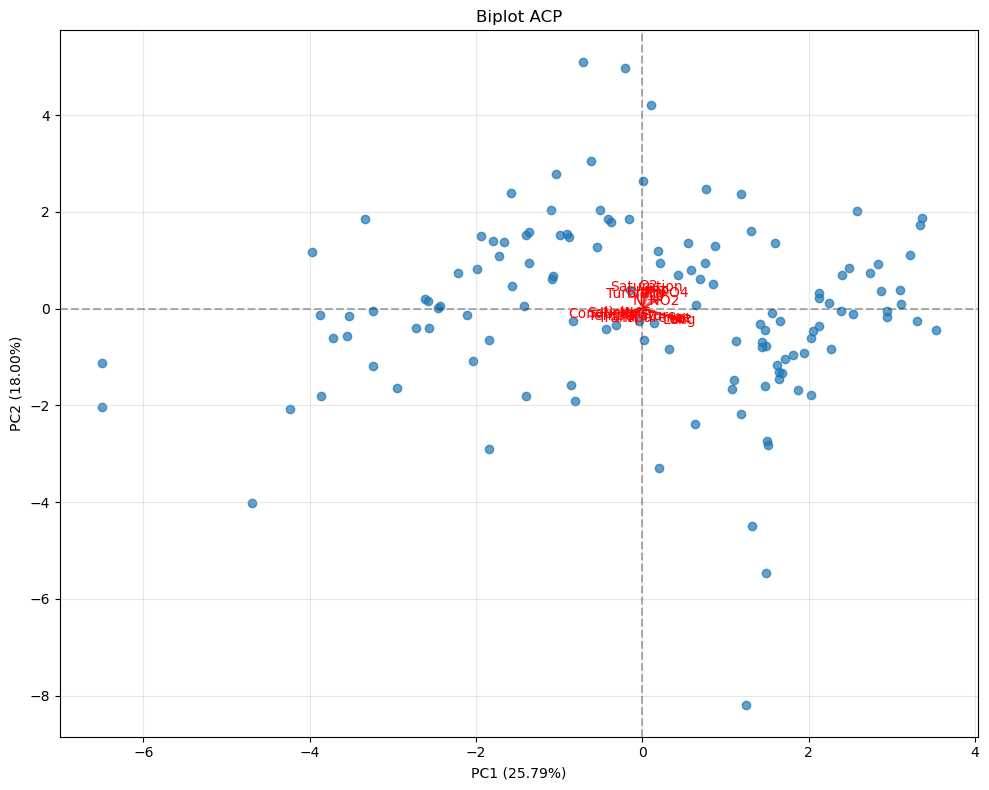

In [61]:


# Biplot
def plot_biplot(pca_result, features, feature_names):
    """Fonction pour créer un biplot"""
    plt.figure(figsize=(10, 8))
    
    # Plot des points
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    
    # Plot des vecteurs des variables
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
                 color='r', alpha=0.5, head_width=0.05)
        plt.text(pca.components_[0, i]*1.15, pca.components_[1, i]*1.15, 
                feature, color='r', ha='center', va='center')
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.title('Biplot ACP')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('pca_biplot.png', dpi=300)
    plt.show()

plot_biplot(pca_result, pca.components_, df_num.columns)

# ANALYSE DISCRIMINANTE LINEAIRE (LDA)

In [62]:
print("\n\n###################################################################")
print("###                 ANALYSE DISCRIMINANTE LINEAIRE (LDA)                ###")
print("####################################################################\n")

# Préparation des données pour LDA
X_lda = df_clean[['Temperature', 'Conductivity', 'Turbidity', 'Salinity', 
                  'O2', 'Chl_a', 'pH', 'NT', 'PT']].dropna()
y_lda = df_clean.loc[X_lda.index, 'Stations']

# LDA
lda = LinearDiscriminantAnalysis()
lda_result = lda.fit(X_lda, y_lda)

# Projections
lda_pred = lda.transform(X_lda)

# Visualisation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(lda_pred[:, 0], lda_pred[:, 1], c=pd.Categorical(y_lda).codes, cmap='viridis')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Séparation des stations sur LD1 et LD2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(y_lda.unique()))
plt.tight_layout()
plt.savefig('lda_plot.png', dpi=300)
plt.close()

# Coefficients LDA
coefficients = pd.DataFrame(lda.scaling_, index=X_lda.columns, columns=[f'LD{i+1}' for i in range(lda.scaling_.shape[1])])
print("Coefficients LDA:")
print(coefficients)



###################################################################
###                 ANALYSE DISCRIMINANTE LINEAIRE (LDA)                ###
####################################################################



AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'scaling_'

# CLUSTERING (K-MEANS)

In [ ]:
print("\n\n###################################################################")
print("###                         CLUSTERING (K-MEANS)                          ###")
print("####################################################################\n")

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=12, n_init=10)
kmeans_result = kmeans.fit_predict(df_num.dropna())

# Ajout des clusters au dataframe
df_clustered = df_num.dropna().copy()
df_clustered['cluster'] = kmeans_result

# Visualisation
plt.figure(figsize=(10, 8))
plt.scatter(df_clustered.iloc[:, 0], df_clustered.iloc[:, 1], c=df_clustered['cluster'], cmap='viridis')
plt.xlabel(df_clustered.columns[0])
plt.ylabel(df_clustered.columns[1])
plt.title('Clustering K-means')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig('kmeans_clustering.png', dpi=300)
plt.close()

print("Résultats K-means:")
print(f"Centroïdes: {kmeans.cluster_centers_}")
print(f"Inertie: {kmeans.inertia_:.2f}")

# ANALYSE OF VARIANCE (ANOVA)

In [ ]:
print("\n\n###################################################################")
print("########                 ANALYSE OF VARIANCE (ANOVA)                   ########")
print("####################################################################\n")

# Tests de normalité
def normality_test_wrapper(data):
    """Applique le test de Shapiro-Wilk sur chaque colonne"""
    results = []
    for col in data.columns:
        if data[col].notna().sum() > 3:  # Minimum 3 observations pour le test
            stat, p_value = shapiro(data[col].dropna())
            results.append({
                'Variable': col,
                'W_Shapiro': round(stat, 2),
                'P_Shapiro': p_value
            })
        else:
            results.append({
                'Variable': col,
                'W_Shapiro': np.nan,
                'P_Shapiro': np.nan
            })
    return pd.DataFrame(results)

normality_results = normality_test_wrapper(df_num)
print("Tests de normalité (Shapiro-Wilk):")
print(normality_results)

# Préparation des données pour ANOVA
param_cols = ["Temperature", "Conductivity", "Salinity", "O2", "Saturation", "pH",
              "Transparence", "Turbidity", "Chl_a", "N_NO2", "N_NH4", "P_PO4", "PT", "NT"]

long_df = df_clean.melt(
    id_vars=['Date', 'Stations'], 
    value_vars=param_cols, 
    var_name='parameter', 
    value_name='value'
).dropna()

long_df['period'] = long_df['Date'].dt.to_period('M')
long_df['period_lab'] = long_df['period'].astype(str)

# Test de Levene pour l'homogénéité des variances
levene_stat, levene_p = levene(*[group['value'].values for name, group in long_df.groupby('parameter')])
print(f"\nTest de Levene: statistic={levene_stat:.3f}, p-value={levene_p:.3f}")

# ANOVA
formula = 'value ~ C(Stations) + C(period_lab) + parameter + C(Stations):C(period_lab)'
model = ols(formula, data=long_df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print("\nRésultats ANOVA:")
print(anova_results)

# ANALYSE SPATIO-TEMPORELLE

In [ ]:
print("\n\n###################################################################")
print("###                    ANALYSE SPATIO-TEMPORELLE                     ###")
print("####################################################################\n")

# Chargement des données spatiales
study_area = gpd.read_file(shp_path)
pts = gpd.GeoDataFrame(
    df_clean, 
    geometry=gpd.points_from_xy(df_clean.Long, df_clean.Lat),
    crs='EPSG:32631'
)

# Reprojection si nécessaire
if study_area.crs != pts.crs:
    study_area = study_area.to_crs(pts.crs)

# Filtrage des points dans la zone d'étude
pts = gpd.sjoin(pts, study_area, predicate='within')

# Préparation des données en format long pour l'analyse spatiale
param_cols_spatial = ["Temperature", "Conductivity", "Salinity", "O2", "Saturation", "pH",
                     "Turbidity", "Transparence", "Chl_a", "N_NO2", "N_NH4", "P_PO4", "NT", "PT"]

long_spatial = pts.melt(
    id_vars=['Date', 'Stations', 'geometry'], 
    value_vars=param_cols_spatial, 
    var_name='parameter', 
    value_name='value'
).dropna()

long_spatial['period'] = long_spatial['Date'].dt.to_period('M')
long_spatial['period_lab'] = long_spatial['period'].astype(str)

# Calcul des limites globales pour chaque paramètre
param_limits = long_spatial.groupby('parameter')['value'].agg(['min', 'max']).reset_index()

def plot_param_points(data_long, area_sf, param, date_from=None, date_to=None, 
                     transform=None, ncols=7, point_size=6, param_limits=None):
    """Fonction pour créer des cartes de points par paramètre"""
    
    d = data_long[data_long['parameter'] == param].copy()
    
    if date_from:
        d = d[d['Date'] >= pd.to_datetime(date_from)]
    if date_to:
        d = d[d['Date'] <= pd.to_datetime(date_to)]
    
    if transform == "log1p":
        d['value_plot'] = np.log1p(np.maximum(d['value'], 0))
        color_label = f"{param} (log1p)"
    else:
        d['value_plot'] = d['value']
        color_label = param
    
    # Obtenir les limites pour ce paramètre
    param_min = param_limits[param_limits['parameter'] == param]['min'].iloc[0]
    param_max = param_limits[param_limits['parameter'] == param]['max'].iloc[0]
    
    # Création du graphique
    unique_periods = d['period_lab'].unique()
    nrows = int(np.ceil(len(unique_periods) / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
    axes = axes.flatten() if nrows > 1 else [axes]
    
    for i, period in enumerate(unique_periods):
        if i < len(axes):
            period_data = d[d['period_lab'] == period]
            
            # Plot de la zone d'étude
            area_sf.boundary.plot(ax=axes[i], color='grey40', linewidth=0.4)
            
            if not period_data.empty:
                # Plot des points
                scatter = period_data.plot(ax=axes[i], column='value_plot', 
                                         markersize=point_size, alpha=0.9, 
                                         legend=False, cmap='viridis',
                                         vmin=param_min, vmax=param_max)
            
            axes[i].set_title(period)
            axes[i].set_axis_off()
    
    # Cacher les axes vides
    for i in range(len(unique_periods), len(axes)):
        axes[i].set_visible(False)
    
    # Ajouter une barre de couleur
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                              norm=plt.Normalize(vmin=param_min, vmax=param_max))
    sm._A = []
    cbar = fig.colorbar(sm, ax=axes, shrink=0.6)
    cbar.set_label(color_label)
    
    plt.tight_layout()
    return fig

# Exemple d'utilisation pour la température
fig_temp = plot_param_points(long_spatial, study_area, "Temperature", 
                            ncols=7, param_limits=param_limits)
plt.savefig("maps_temperature_points.png", dpi=300, bbox_inches='tight')
plt.close()

# Interpolation IDW
def idw_interpolation(points, target_points, power=2):
    """Interpolation par Inverse Distance Weighting"""
    distances = cdist(target_points, points)
    weights = 1 / (distances ** power)
    weights[weights == np.inf] = 1  # Gérer les distances nulles
    weights = weights / weights.sum(axis=1, keepdims=True)
    return weights

def idw_param_map_sf(data_long, area_sf, param, cellsize=100, date_from=None, 
                    date_to=None, idp=2, nmax=12, crs_proj=3857, ncol=3, global_limits=None):
    """Fonction pour créer des cartes d'interpolation IDW"""
    
    d = data_long[data_long['parameter'] == param].copy()
    
    if date_from:
        d = d[d['Date'] >= pd.to_datetime(date_from)]
    if date_to:
        d = d[d['Date'] <= pd.to_datetime(date_to)]
    
    # Reprojection
    area_prj = area_sf.to_crs(crs_proj)
    d_prj = d.to_crs(crs_proj)
    
    periods = sorted(d_prj['period_lab'].unique())
    
    # Limites globales
    param_min = global_limits[global_limits['parameter'] == param]['min'].iloc[0]
    param_max = global_limits[global_limits['parameter'] == param]['max'].iloc[0]
    
    # Création de la grille
    bounds = area_prj.total_bounds
    x = np.arange(bounds[0], bounds[2], cellsize)
    y = np.arange(bounds[1], bounds[3], cellsize)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Filtrer les points dans la zone d'étude
    grid_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
        crs=area_prj.crs
    )
    grid_gdf = gpd.sjoin(grid_gdf, area_prj, predicate='within')
    
    nrows = int(np.ceil(len(periods) / ncol))
    fig, axes = plt.subplots(nrows, ncol, figsize=(ncol*4, nrows*4))
    axes = axes.flatten() if nrows > 1 else [axes]
    
    for i, period in enumerate(periods):
        if i < len(axes):
            period_data = d_prj[d_prj['period_lab'] == period]
            
            if len(period_data) >= 3:
                # Points d'observation
                obs_points = np.array([point.coords[0] for point in period_data.geometry])
                obs_values = period_data['value'].values
                
                # Points cibles
                target_points = np.array([point.coords[0] for point in grid_gdf.geometry])
                
                # Interpolation IDW
                weights = idw_interpolation(obs_points, target_points, power=idp)
                pred_values = weights.dot(obs_values)
                
                # Création de la grille de prédiction
                grid_gdf_period = grid_gdf.copy()
                grid_gdf_period['pred'] = pred_values
                
                # Plot
                area_prj.boundary.plot(ax=axes[i], color='grey30', linewidth=0.3)
                grid_gdf_period.plot(ax=axes[i], column='pred', cmap='viridis', 
                                   vmin=param_min, vmax=param_max, legend=False)
            
            axes[i].set_title(period)
            axes[i].set_axis_off()
    
    # Cacher les axes vides
    for i in range(len(periods), len(axes)):
        axes[i].set_visible(False)
    
    # Barre de couleur
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                              norm=plt.Normalize(vmin=param_min, vmax=param_max))
    sm._A = []
    cbar = fig.colorbar(sm, ax=axes, shrink=0.6)
    cbar.set_label(param)
    
    plt.tight_layout()
    return fig

# Application de l'interpolation IDW
global_limits_spatial = long_spatial.groupby('parameter')['value'].agg(['min', 'max']).reset_index()

# Température
fig_temp_idw = idw_param_map_sf(long_spatial, study_area, "Temperature",
                               date_from="2023-01-01", date_to="2024-12-31",
                               cellsize=100, ncol=7, global_limits=global_limits_spatial)
plt.savefig("temperature_idw_2024.png", dpi=300, bbox_inches='tight')
plt.close()

# ANALYSE STATISTIQUE COMPLÈTE

In [ ]:
print("\n\n###################################################################")
print("###                    ANALYSE STATISTIQUE COMPLÈTE                    ###")
print("####################################################################\n")

# Statistiques descriptives par paramètre et période
stat_desc_period = long_df.groupby(['parameter', 'period_lab']).agg({
    'value': ['mean', 'std', 'min', 'max', 'count']
}).round(2)

print("Statistiques descriptives par paramètre et période:")
print(stat_desc_period)

# Graphique des tendances temporelles
plt.figure(figsize=(12, 8))
for station in df_clean['Stations'].unique():
    station_data = df_clean[df_clean['Stations'] == station]
    plt.plot(station_data['Date'], station_data['Temperature'], 
             label=station, marker='o', markersize=3)

plt.title('Tendance de la température dans le temps')
plt.xlabel('Date')
plt.ylabel('Température')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('temperature_trends.png', dpi=300, bbox_inches='tight')
plt.close()

# Histogramme de la température
plt.figure(figsize=(10, 6))
plt.hist(df_clean['Temperature'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution de la température')
plt.xlabel('Température')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.savefig('temperature_histogram.png', dpi=300, bbox_inches='tight')
plt.close()

# Scatter plot température vs salinité
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['Temperature'], df_clean['Salinity'], alpha=0.6)
plt.title('Température vs Salinité')
plt.xlabel('Température')
plt.ylabel('Salinité')
plt.tight_layout()
plt.savefig('temp_vs_salinity.png', dpi=300, bbox_inches='tight')
plt.close()

# Carte des stations
plt.figure(figsize=(10, 8))
study_area.boundary.plot(color='black', linewidth=1)
pts.plot(ax=plt.gca(), column='Stations', legend=True, markersize=50)
plt.title('Localisation des Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('stations_map.png', dpi=300, bbox_inches='tight')
plt.close()

print("\nAnalyse terminée avec succès!")
print("Tous les graphiques ont été sauvegardés dans le répertoire de travail.")

In [ ]:
# Pour chaque paramètre, nous traçons un boxplot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Crée une grille de 3x3 pour les graphiques
fig.subplots_adjust(hspace=0.5)

# Liste des paramètres à tracer
parameters = ['Transparency', 'Conductivity', 'Salinity', 'Dissolved_Oxygen', 'Temperature', 'pH', 'Saturation_Oxygen', 'Depth']

# Liste des titres pour chaque graphique
titles = ['Transparence', 'Conductivité', 'Salinité', 'Oxygène Dissous', 'Température', 'pH', 'Taux de Saturation en Oxygène Dissous', 'Profondeur']

# Tracer chaque boxplot
for i, param in enumerate(parameters):
    ax = axes[i // 3, i % 3]  # Sélectionner le sous-graphe dans la grille 3x3
    sns.boxplot(x='Stations', y=param, data=df, ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('Stations')
    ax.set_ylabel(param)

plt.show()

# Calcul de l'indice de qualité de l'eau (IQE)

In [61]:
df_num.head()

Temperature  Conductivity  Salinity    O2  Saturation    pH  Transparence  \
0         30.7         48.10      31.7  6.43        85.9  7.95         70.57   
1         30.6         19.08      11.4  4.90        65.8  7.24         46.00   
2         30.0         14.50       8.5  6.18        80.8  8.01         20.00   
3         33.0         24.80      15.2  8.04       112.1  8.40         45.00   
4         32.5         18.36      11.0  7.16        99.8  8.01         29.00   

   Turbidity  Chl_a  N_NO2  N_NH4   P_PO4      PT     NT  
0      26.94   7.12   1.73  51.76   34.51  153.94   9.51  
1      24.72   2.14   6.25  87.92   45.41  161.60  19.67  
2      27.34   3.20   1.73  51.18   35.28   63.85  37.63  
3      30.28   8.54   1.44  90.12  172.74  393.98  25.18  
4      56.40   6.41   5.40  99.98   88.82  123.30  18.32

In [62]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   130 non-null    float64
 1   Conductivity  130 non-null    float64
 2   Salinity      130 non-null    float64
 3   O2            130 non-null    float64
 4   Saturation    130 non-null    float64
 5   pH            130 non-null    float64
 6   Transparence  130 non-null    float64
 7   Turbidity     130 non-null    float64
 8   Chl_a         130 non-null    float64
 9   N_NO2         130 non-null    float64
 10  N_NH4         130 non-null    float64
 11  P_PO4         130 non-null    float64
 12  PT            130 non-null    float64
 13  NT            130 non-null    float64
dtypes: float64(14)
memory usage: 14.3 KB


In [69]:
df_num['Stations'] = df_clean['Stations']


In [71]:
df_num.head(10)

Temperature  Conductivity  Salinity    O2  Saturation     pH  Transparence  \
0         30.7         48.10      31.7  6.43        85.9  7.950         70.57   
1         30.6         19.08      11.4  4.90        65.8  7.240         46.00   
2         30.0         14.50       8.5  6.18        80.8  8.010         20.00   
3         33.0         24.80      15.2  8.04       112.1  8.400         45.00   
4         32.5         18.36      11.0  7.16        99.8  8.010         29.00   
5         31.7         13.70       8.0  7.48       101.2  8.205         47.00   
6         29.4         28.40      17.6  7.98       103.9  8.520         98.00   
7         30.6         17.91      10.7  6.94        92.7  7.990         75.00   
8         29.9         14.09       8.2  7.15        93.8  8.320         90.00   
9         30.7         14.15       8.6  7.37        98.4  8.400        136.00   

   Turbidity  Chl_a  N_NO2   N_NH4   P_PO4      PT     NT Stations  Conformite  
0      26.94   7.12   1.73   51.76   34.51  153.94   9.51       A1           0  
1      24.72   2.14   6.25   87.92   45.41  161.60  19.67       A1           0  
2      27.34   3.20   1.73   51.18   35.28   63.85  37.63       A1           0  
3      30.28   8.54   1.44   90.12  172.74  393.98  25.18      A10           0  
4      56.40   6.41   5.40   99.98   88.82  123.30  18.32      A10           0  
5      39.66   3.20   4.84   82.19   36.82   66.17  28.13      A10           0  
6       6.14   4.22   0.88   52.85   10.95  286.73  12.76       A2           0  
7      13.96   5.34   7.38  165.74   99.04  193.52  13.80       A2           0  
8      11.16   1.07   1.44   51.46   49.95   72.35  28.13       A2           0  
9       6.09   1.34   1.16   63.81  214.44  386.32  13.24       A3           0

In [66]:
# Seuils Ifremer pour un lac
normes = {
    'Temperature': 30,
    'Conductivity': 1300,
    'O2': 5,
    'pH_min': 6.5,
    'pH_max': 8.5,
    'Transparence': 30,
    'Turbidity': 5,
    'Chl_a': 4,
    'N_NO2': 0.1,
    'N_NH4': 0.1,
    'P_PO4': 0.03,
    'PT': 0.05,
    'NT': 1.0
}

In [67]:
# Fonction qui vérifie pour une ligne si un paramètre dépasse la norme
def compare_avec_normes(row, normes):
    for parametre, valeur_norme in normes.items():
        if parametre in row and row[parametre] > valeur_norme:
            return 0  # au moins une valeur dépasse la norme
    return 1  # toutes les valeurs sont conformes

# Application de la fonction à chaque ligne du dataframe
df_num['Conformite'] = df_num.apply(compare_avec_normes, axis=1, normes=normes)

df_num.head()


Temperature  Conductivity  Salinity    O2  Saturation    pH  Transparence  \
0         30.7         48.10      31.7  6.43        85.9  7.95         70.57   
1         30.6         19.08      11.4  4.90        65.8  7.24         46.00   
2         30.0         14.50       8.5  6.18        80.8  8.01         20.00   
3         33.0         24.80      15.2  8.04       112.1  8.40         45.00   
4         32.5         18.36      11.0  7.16        99.8  8.01         29.00   

   Turbidity  Chl_a  N_NO2  N_NH4   P_PO4      PT     NT Stations  Conformite  
0      26.94   7.12   1.73  51.76   34.51  153.94   9.51       A1           0  
1      24.72   2.14   6.25  87.92   45.41  161.60  19.67       A1           0  
2      27.34   3.20   1.73  51.18   35.28   63.85  37.63       A1           0  
3      30.28   8.54   1.44  90.12  172.74  393.98  25.18      A10           0  
4      56.40   6.41   5.40  99.98   88.82  123.30  18.32      A10           0

In [68]:
df_num['Conformite'].unique()

array([0], dtype=int64)

In [29]:
dfgp = round(df_num.groupby("Stations").mean(),3)
dfgp.head()

Temperature  Conductivity  Salinity     O2  Saturation     pH  \
Stations                                                                  
A1             28.854        13.829     8.892  6.495      83.800  7.942   
A10            30.638         8.597     5.154  7.455      99.454  8.251   
A2             28.754         8.705     5.085  7.328      94.368  8.301   
A3             29.115         6.029     3.415  7.378      95.200  8.262   
A4             29.331         4.545     2.554  7.486      97.592  8.279   

          Transparence  Turbidity  Chl_a  N_NO2   N_NH4    P_PO4       PT  \
Stations                                                                    
A1              42.916     48.891  4.268  5.968  85.797  118.983  218.907   
A10             40.372     52.576  6.795  7.844  70.325  149.382  259.901   
A2              65.192     44.245  5.806  6.595  69.215  130.227  260.649   
A3              76.077     30.055  3.862  6.265  60.504  167.921  253.590   
A4              65.372     28.698  4.050  7.088  51.004  163.447  280.702   

              NT  
Stations          
A1        17.283  
A10       21.864  
A2        17.904  
A3        18.591  
A4        17.386

In [32]:
dfgp['N_NH4'] = dfgp['N_NH4'] /1000
dfgp['N_NO2'] = dfgp['N_NO2'] /1000
dfgp['PT'] = dfgp['PT'] /1000
dfgp['P_PO4'] = dfgp['P_PO4'] /1000
dfgp

Temperature  Conductivity  Salinity     O2  Saturation     pH  \
Stations                                                                  
A1             28.854        13.829     8.892  6.495      83.800  7.942   
A10            30.638         8.597     5.154  7.455      99.454  8.251   
A2             28.754         8.705     5.085  7.328      94.368  8.301   
A3             29.115         6.029     3.415  7.378      95.200  8.262   
A4             29.331         4.545     2.554  7.486      97.592  8.279   
A5             29.323         3.208     1.815  7.346      95.508  8.269   
A6             29.338         2.391     1.246  7.291      95.285  8.231   
A7             29.662         2.505     0.892  6.351      85.031  8.068   
A8             29.862         4.780     2.723  7.620     101.185  8.322   
A9             29.831         6.250     3.538  7.788     102.485  8.364   

          Transparence  Turbidity  Chl_a     N_NO2     N_NH4     P_PO4  \
Stations                                                                 
A1              42.916     48.891  4.268  0.005968  0.000086  0.118983   
A10             40.372     52.576  6.795  0.007844  0.000070  0.149382   
A2              65.192     44.245  5.806  0.006595  0.000069  0.130227   
A3              76.077     30.055  3.862  0.006265  0.000061  0.167921   
A4              65.372     28.698  4.050  0.007088  0.000051  0.163447   
A5              65.910     27.374  3.840  0.008037  0.000055  0.180188   
A6              57.654     28.077  6.143  0.009577  0.000063  0.185656   
A7              50.192     26.606  5.309  0.011098  0.000059  0.170393   
A8              65.038     39.066  4.618  0.007385  0.000056  0.184136   
A9              52.385     50.521  5.245  0.007632  0.000054  0.168763   

                PT      NT  
Stations                    
A1        0.218907  17.283  
A10       0.259901  21.864  
A2        0.260649  17.904  
A3        0.253590  18.591  
A4        0.280702  17.386  
A5        0.274038  19.027  
A6        0.294579  16.763  
A7        0.286855  14.294  
A8        0.281328  19.215  
A9        0.277110  18.313

## Selon la méthode de l'indice arithmétique pondéré

In [33]:
df = dfgp
# Dictionnaire des normes basé sur la grille de qualité des eaux de surface
normes = {
    'Temperature': 30,  # Norme pour la température (en °C)
    'pH': 9,  # Norme pour le pH
    'Conductivity': 1300,  # Norme pour la conductivité (en µS/cm)
    'O2': 5,  # Norme pour l'oxygène dissous (en mg/L)
    'PO4': 1,  # Norme pour les phosphates (PO4) (en mg/L)
    'N_NO2': 0.5,  # Norme pour les nitrites (NO2)
    'N_NH4': 2,  # Norme pour l'ammonium (NH4)
    'N_NO3': 50,  # Norme pour les nitrates (NO3)
    'Chl_a': 30,  # Norme pour la chlorophylle-a (Chl_a)
    'Turbidity': 5,  # Norme pour la turbidité
    'PT':0.5,
    # Ajouter d'autres paramètres et leurs normes ici selon votre grille
}

# Liste des paramètres présents dans le DataFrame
parametres = [
    'Temperature', 'Conductivity', 'O2', 'pH',
     'Chl_a', 'N_NH4', 'P_PO4', 'PT',
]

# Créer un DataFrame vide pour stocker les données sous format long
df_long = pd.DataFrame(columns=['Parametre', 'Concentration', 'Norme'])

# Remplir le DataFrame avec les données
for param in parametres:
    if param in df.columns:  # Vérifier que le paramètre existe dans le dataset
        # Extraire la colonne correspondante à chaque paramètre
        concentration = df[param]
        # Récupérer la norme pour chaque paramètre
        norme = normes.get(param, None)
        
        if norme is not None:
            # Créer un DataFrame temporaire pour chaque paramètre
            temp_df = pd.DataFrame({
                'Parametre': [param] * len(concentration),
                'Concentration': concentration,
                'Norme': [norme] * len(concentration)
            })
            # Ajouter les données au DataFrame long
            df_long = pd.concat([df_long, temp_df], ignore_index=True)

# Afficher le DataFrame transformé
print(df_long)

# Vous pouvez également enregistrer ce DataFrame sous un nouveau fichier Excel si nécessaire
#df_long.to_excel('votre_fichier_transforme.xlsx', index=False)


      Parametre  Concentration Norme
0   Temperature      28.854000    30
1   Temperature      30.638000    30
2   Temperature      28.754000    30
3   Temperature      29.115000    30
4   Temperature      29.331000    30
..          ...            ...   ...
65           PT       0.274038   0.5
66           PT       0.294579   0.5
67           PT       0.286855   0.5
68           PT       0.281328   0.5
69           PT       0.277110   0.5

[70 rows x 3 columns]


In [34]:
# Fonction pour calculer k
def calcul_k(Si):
    k = 1 / sum(1 / Si_i for Si_i in Si)
    return k

# Fonction pour calculer le poids relatif Wi pour chaque paramètre
def calcul_poids(Si, k):
    Wi = [k / Si_i for Si_i in Si]
    return Wi

# Fonction pour calculer Qi pour chaque paramètre
def calcul_qi(Ci, Si):
    qi = [(Ci_i / Si_i) * 100 for Ci_i, Si_i in zip(Ci, Si)]
    return qi

# Fonction pour calculer l'IQE global
def calcul_IQE(Qi, Wi):
    numerator = sum(Qi_i * Wi_i for Qi_i, Wi_i in zip(Qi, Wi))
    denominator = sum(Wi)
    IQE = numerator / denominator
    return IQE

# Le fichier contient les colonnes suivantes :
# - 'Paramètre' : le nom du paramètre
# - 'Concentration' : la concentration mesurée (Ci)
# - 'Norme' : la norme de qualité (Si)

# Extraire les données nécessaires pour le calcul
Ci = df_long['Concentration'].tolist()  # Liste des concentrations
Si = df_long['Norme'].tolist()  # Liste des valeurs de norme

# Calcul de k
k = calcul_k(Si)

# Calcul des poids relatifs Wi
Wi = calcul_poids(Si, k)

# Calcul des échelles d'évaluation de la qualité Qi
Qi = calcul_qi(Ci, Si)

# Calcul de l'IQE global
IQE = calcul_IQE(Qi, Wi)

# Affichage du résultat
print(f"L'indice global de qualité de l'eau (IQE) est : {IQE}")


L'indice global de qualité de l'eau (IQE) est : 52.287487395525645


## Calculer l'indice CCME

In [ ]:
import pandas as pd
import numpy as np

# Fonction pour calculer le sous-indice C (concentration)
def sous_indice_C(Ci, Si):
    """Calcul du sous-indice de concentration"""
    return np.clip((Ci / Si) * 100, 0, 100)  # Assure que la valeur reste entre 0 et 100

# Fonction pour calculer le sous-indice V (variabilité)
def sous_indice_V(concentrations, Si):
    """Calcul du sous-indice de variabilité"""
    std_dev = np.std(concentrations)
    return np.clip((std_dev / Si) * 100, 0, 100)  # Assure que la valeur reste entre 0 et 100

# Fonction pour calculer le sous-indice F (fréquence)
def sous_indice_F(concentrations, Si):
    """Calcul du sous-indice de fréquence"""
    frequency = np.sum(concentrations > Si) / len(concentrations)
    return np.clip(frequency * 100, 0, 100)  # Assure que la valeur reste entre 0 et 100

# Fonction pour calculer l'indice CCME
def calcul_CCME(Ci, Si, concentrations):
    """Calcul de l'indice CCME"""
    C = sous_indice_C(Ci, Si)
    V = sous_indice_V(concentrations, Si)
    F = sous_indice_F(concentrations, Si)
    
    # L'indice CCME est la moyenne de ces sous-indices
    CCME = np.mean([C, V, F])
    
    return CCME

# Charger votre dataset .xlsx
file_path = 'votre_fichier.xlsx'  # Remplacez par le chemin vers votre fichier
df = pd.read_excel(file_path, engine='openpyxl')

# Dictionnaire des normes basé sur la grille de qualité des eaux de surface
normes = {
    'Temperature': 25,  # Norme pour la température (en °C)
    'pH': 8.5,  # Norme pour le pH
    'Conductivity': 1300,  # Norme pour la conductivité (en µS/cm)
    'Salinity': 35,  # Norme pour la salinité (en g/L)
    'O2': 7,  # Norme pour l'oxygène dissous (en mg/L)
    'DBO': 3,  # Norme pour la demande biochimique en oxygène (en mg/L)
    'PO4': 0.2,  # Norme pour les phosphates (PO4) (en mg/L)
    'N_NO2': 0.5,  # Norme pour les nitrites (NO2)
    'N_NH4': 1,  # Norme pour l'ammonium (NH4)
    'N_NO3': 10,  # Norme pour les nitrates (NO3)
    'Chl_a': 20,  # Norme pour la chlorophylle-a (Chl_a)
    'Turbidity': 5,  # Norme pour la turbidité
}

# Liste des paramètres présents dans le DataFrame
parametres = [
    'Temperature', 'Conductivity', 'Salinity', 'O2', 'pH', 'Redox', 'Transparence',
    'Turbidity', 'Chl_a', 'N_NO2', 'N_NH4', 'N_NO3', 'P_PO4', 'PT', 'NT'
]

# Créer un DataFrame pour stocker les résultats de l'indice CCME
ccme_results = pd.DataFrame(columns=['Parametre', 'Indice_CCME'])

# Remplir le DataFrame avec les résultats de l'indice CCME
for param in parametres:
    if param in df.columns:
        # Extraire la concentration moyenne pour chaque paramètre
        concentration_moyenne = df[param].mean()
        
        # Récupérer la norme pour chaque paramètre
        norme = normes.get(param, None)
        
        if norme is not None:
            # Calculer l'indice CCME pour ce paramètre
            CCME = calcul_CCME(concentration_moyenne, norme, df[param])
            
            # Ajouter les résultats au DataFrame
            ccme_results = ccme_results.append({'Parametre': param, 'Indice_CCME': CCME}, ignore_index=True)

# Afficher les résultats de l'indice CCME pour chaque paramètre
print(ccme_results)

# Sauvegarder les résultats dans un fichier Excel si nécessaire
ccme_results.to_excel('resultats_indice_CCME.xlsx', index=False)


In [ ]:
# Fonction pour calculer k
def calcul_k(Si):
    """
    Calcule la constante k
    Si : liste des valeurs maximales de la norme pour chaque paramètre
    """
    k = 1 / sum(1 / Si_i for Si_i in Si)
    return k

# Fonction pour calculer le poids relatif Wi pour chaque paramètre
def calcul_poids(Si, k):
    """
    Calcule les poids relatifs Wi pour chaque paramètre
    Si : liste des valeurs maximales de la norme pour chaque paramètre
    k  : constante de proportionnalité
    """
    poids = [k / Si_i for Si_i in Si]
    return poids

# Fonction pour calculer Qi pour chaque paramètre
def calcul_qi(Ci, Si):
    """
    Calcule l'échelle d'évaluation de la qualité Qi pour chaque paramètre
    Ci : concentration mesurée de chaque paramètre
    Si : norme maximale pour chaque paramètre
    """
    qi = [(Ci_i / Si_i) * 100 for Ci_i, Si_i in zip(Ci, Si)]
    return qi

# Fonction pour calculer l'IQE global
def calcul_IQE(Qi, Wi):
    """
    Calcule l'indice global de qualité de l'eau IQE
    Qi : liste des échelles d'évaluation pour chaque paramètre
    Wi : liste des poids relatifs pour chaque paramètre
    """
    numerator = sum(Qi_i * Wi_i for Qi_i, Wi_i in zip(Qi, Wi))
    denominator = sum(Wi)
    IQE = numerator / denominator
    return IQE

# Définir les valeurs des paramètres (exemple)
Si = [7, 100, 200, 500]  # Exemple de normes maximales pour 4 paramètres
Ci = [3, 50, 150, 400]  # Exemple de concentrations mesurées pour 4 paramètres

# Calcul de k
k = calcul_k(Si)

# Calcul des poids relatifs Wi
Wi = calcul_poids(Si, k)

# Calcul des échelles d'évaluation de la qualité Qi
Qi = calcul_qi(Ci, Si)

# Calcul de l'IQE global
IQE = calcul_IQE(Qi, Wi)

# Affichage du résultat
print(f"L'indice global de qualité de l'eau (IQE) est : {IQE}")


In [12]:
import pandas as pd

# Exemple de dataframe avec paramètres d'un lac (à remplacer par vos données réelles)
data = {
    'Temperature': [15, 22, 18],
    'Conductivity': [900, 1100, 950],
    'Salinity': [0.4, 0.55, 0.3],
    'O2': [8, 6, 9],
    'pH': [7, 8.6, 7.8],
    'Transparence': [32, 25, 30],
    'Turbidity': [3, 6, 4],
    'Chl_a': [3, 5, 4],
    'N_NO2': [0.08, 0.12, 0.09],
    'N_NH4': [0.08, 0.15, 0.1],
    'P_PO4': [0.02, 0.04, 0.03],
    'PT': [0.04, 0.06, 0.05],
    'NT': [0.9, 1.2, 1.0]
}
df = pd.DataFrame(data)

# Seuils Ifremer pour un lac
normes_lac = {
    'Temperature': 20,
    'Conductivity': 1000,
    'Salinity': 0.5,
    'O2': 7,
    'pH_min': 6.5,
    'pH_max': 8.5,
    'Transparence': 30,
    'Turbidity': 5,
    'Chl_a': 4,
    'N_NO2': 0.1,
    'N_NH4': 0.1,
    'P_PO4': 0.03,
    'PT': 0.05,
    'NT': 1.0
}

def compare_lac(row, normes):
    # Test des paramètres avec seuils supérieurs
    for param in ['Temperature', 'Conductivity', 'Salinity', 'Transparence', 'Turbidity', 'Chl_a', 'N_NO2', 'N_NH4', 'P_PO4', 'PT', 'NT']:
        if param in row:
            val = row[param]
            seuil = normes[param]
            if param == 'Transparence':  # Transparence seuil minimum
                if val < seuil:
                    return 0
            else:  # Seuil maximum
                if val > seuil:
                    return 0
    # Cas particulier du pH entre min et max
    if 'pH' in row:
        if row['pH'] < normes['pH_min'] or row['pH'] > normes['pH_max']:
            return 0
    # Cas oxygène seuil minimum
    if 'O2' in row and row['O2'] < normes['O2']:
        return 0

    return 1

# Application au dataframe
df['Conformite'] = df.apply(compare_lac, axis=1, normes=normes_lac)

print(df)


   Temperature  Conductivity  Salinity  O2   pH  Transparence  Turbidity  \
0           15           900      0.40   8  7.0            32          3   
1           22          1100      0.55   6  8.6            25          6   
2           18           950      0.30   9  7.8            30          4   

   Chl_a  N_NO2  N_NH4  P_PO4    PT   NT  Conformite  
0      3   0.08   0.08   0.02  0.04  0.9           1  
1      5   0.12   0.15   0.04  0.06  1.2           0  
2      4   0.09   0.10   0.03  0.05  1.0           1  


In [9]:
import pandas as pd

# Exemple de dataframe avec des observations
# Remplacer 'df' par votre dataframe réel avec les mêmes colonnes
# Exemple simplifié ici avec 3 observations et les paramètres d'intérêt
data = {
    'Temperature': [15, 22, 18],
    'Conductivity': [100, 150, 90],
    'Salinity': [0.5, 0.6, 0.4],
    'O2': [8, 7, 9],
    'pH': [7, 7.5, 6.8],
    'Transparence': [20, 25, 30],
    'Turbidity': [1, 2, 1],
    'Chl_a': [5, 4, 3],
    'N_NO2': [0.1, 0.15, 0.12],
    'N_NH4': [0.05, 0.07, 0.06],
    'P_PO4': [0.02, 0.03, 0.01],
    'PT': [0.5, 0.6, 0.4],
    'NT': [1, 1.2, 1.1]
}
df = pd.DataFrame(data)

# Dictionnaire des normes pour chaque paramètre
normes = {
    'Temperature': 20,
    'Conductivity': 120,
    'Salinity': 0.6,
    'O2': 9,
    'pH': 8,
    'Transparence': 30,
    'Turbidity': 3,
    'Chl_a': 6,
    'N_NO2': 0.12,
    'N_NH4': 0.06,
    'P_PO4': 0.03,
    'PT': 0.55,
    'NT': 1.1
}

# Fonction qui vérifie pour une ligne si un paramètre dépasse la norme
def compare_avec_normes(row, normes):
    for parametre, valeur_norme in normes.items():
        if parametre in row and row[parametre] > valeur_norme:
            return 0  # au moins une valeur dépasse la norme
    return 1  # toutes les valeurs sont conformes

# Application de la fonction à chaque ligne du dataframe
df['Conformite'] = df.apply(compare_avec_normes, axis=1, normes=normes)

print(df)


   Temperature  Conductivity  Salinity  O2   pH  Transparence  Turbidity  \
0           15           100       0.5   8  7.0            20          1   
1           22           150       0.6   7  7.5            25          2   
2           18            90       0.4   9  6.8            30          1   

   Chl_a  N_NO2  N_NH4  P_PO4   PT   NT  Conformite  
0      5   0.10   0.05   0.02  0.5  1.0           1  
1      4   0.15   0.07   0.03  0.6  1.2           0  
2      3   0.12   0.06   0.01  0.4  1.1           1  


In [10]:
df.head()

Temperature  Conductivity  Salinity  O2   pH  Transparence  Turbidity  \
0           15           100       0.5   8  7.0            20          1   
1           22           150       0.6   7  7.5            25          2   
2           18            90       0.4   9  6.8            30          1   

   Chl_a  N_NO2  N_NH4  P_PO4   PT   NT  Conformite  
0      5   0.10   0.05   0.02  0.5  1.0           1  
1      4   0.15   0.07   0.03  0.6  1.2           0  
2      3   0.12   0.06   0.01  0.4  1.1           1

TypeError: Invalid object type at position 3

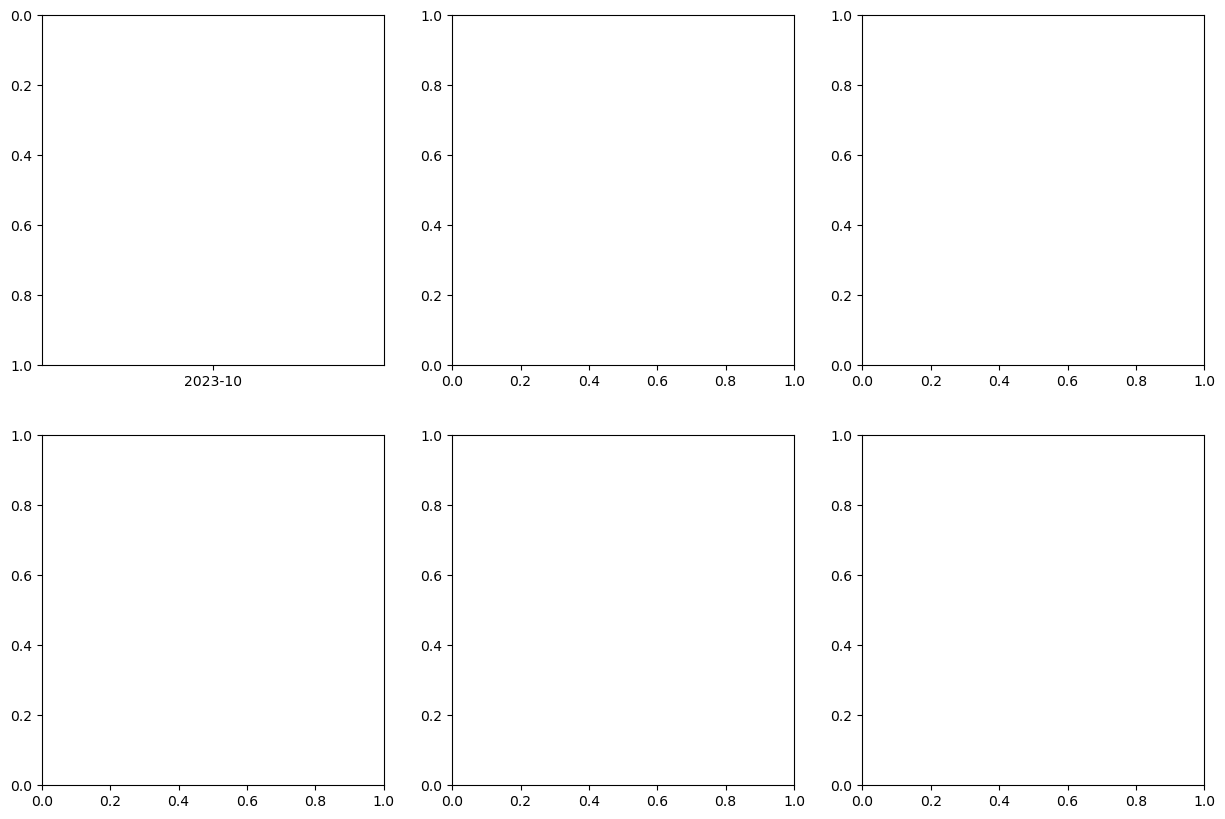

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have a DataFrame `data` with 'Mois' for months, 'Station' for stations, 
# and columns for 'O2', 'Chl_a', and 'Turbidity'. You need to adjust the DataFrame 
# structure to match your actual data.

# Example DataFrame structure:
data = pd.DataFrame({
    'Mois': ['2023-10', '2023-11', '2023-12', ...],
    'Station': ['A1', 'A2', 'A3', ...],
    'O2': [7, 6, 5, ...],
    'Chl_a': [3.5, 4.2, 4.0, ...],
    'Turbidity': [20, 30, 40, ...],
})

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes for easier iteration
axes = axes.flatten()

# List of the variables you want to plot
variables = ['O2', 'Chl_a', 'Turbidity']

# First, plot by month (x-axis will be months)
for i, var in enumerate(variables):
    sns.boxplot(x='Mois', y=var, data=data, ax=axes[i])
    axes[i].set_title(f'{var} par mois')
    axes[i].set_ylabel(var)
    axes[i].set_xlabel('Mois')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate month labels for readability

# Then, plot by station (x-axis will be stations)
for i, var in enumerate(variables):
    sns.boxplot(x='Station', y=var, data=data, ax=axes[i + 3])
    axes[i + 3].set_title(f'{var} par stations')
    axes[i + 3].set_ylabel(var)
    axes[i + 3].set_xlabel('Stations')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
